In [1]:
!nvidia-smi

Tue Jun 10 18:31:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%pip install ultralytics roboflow
!pip install ultralytics
import ultralytics
!pip install optuna
ultralytics.checks()


Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.8/112.6 GB disk)


# **Importamos el Dataset en formato zip**

In [3]:
import zipfile
import os

with zipfile.ZipFile('/content/egg_detection_dataset11.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')


In [4]:
os.listdir('dataset')


['valid',
 'README.roboflow.txt',
 'test',
 'data.yaml',
 'train',
 'README.dataset.txt']

In [ ]:
import os
os.listdir("dataset/train/images")[:5]
os.listdir("dataset/train/labels")[:5]


['istockphoto-151518648-612x612_jpg.rf.377cd73e10fa403e0eea701bd7d6175a.txt',
 '57_jpg.rf.6bd39271a928b080089fd6db832ddfa3.txt',
 '4940621200258871178_jpg.rf.7f0e2cea3d65634ab5cedd681fa5ffe0.txt',
 '240_F_113268897_xc8WhncecRJGcjK1V1Lf6VRU4qwg73Mv_jpg.rf.2adc15c27a8001b7acc2944d4351f9d6.txt',
 'not_damaged_111_jpg.rf.34a41bfe09d544b530fd6892d3ae6ebe.txt']

In [ ]:
with open("dataset/data.yaml", 'r') as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['broken-egg', 'good-egg']

roboflow:
  workspace: eggs-hcgmj
  project: egg-detection-2
  version: 6
  license: CC BY 4.0
  url: https://universe.roboflow.com/eggs-hcgmj/egg-detection-2/dataset/6


# **Busqueda de los mejores hiperparametros**

In [ ]:
import optuna
from ultralytics import YOLO
import os

# Directorio donde guardar los resultados
SAVE_DIR = "optuna_yolo_runs"

def objective(trial):
    trial_params = {
        'lr0': trial.suggest_float('lr0', 1e-5, 1e-1, log=True),
        'lrf': trial.suggest_float('lrf', 0.01, 1.0),
        'momentum': trial.suggest_float('momentum', 0.6, 0.98),
        'weight_decay': trial.suggest_float('weight_decay', 0.0001, 0.01),
        'warmup_epochs': trial.suggest_float('warmup_epochs', 0.0, 5.0),
        'box': trial.suggest_float('box', 0.02, 0.2),
        'cls': trial.suggest_float('cls', 0.2, 0.5),
        'dfl': trial.suggest_float('dfl', 0.5, 1.0),
        'hsv_h': trial.suggest_float('hsv_h', 0.0, 0.1),
        'hsv_s': trial.suggest_float('hsv_s', 0.0, 0.9),
        'hsv_v': trial.suggest_float('hsv_v', 0.0, 0.9),
        'flipud': trial.suggest_float('flipud', 0.0, 0.5),
        'fliplr': trial.suggest_float('fliplr', 0.0, 0.5),
        'mosaic': trial.suggest_float('mosaic', 0.0, 1.0),
        'mixup': trial.suggest_float('mixup', 0.0, 1.0)
    }

    model = YOLO("yolov8n.pt")

    results = model.train(
        data="/content/dataset/data.yaml",
        epochs=20,
        imgsz=640,
        **trial_params
    )

    metrics = model.val()
    map50 = metrics.box.map50

    return map50

# Crear estudio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)  # Cambia según tu tiempo y recursos

# Mostrar mejores hiperparámetros
print("Best trial:")
print(study.best_trial.params)


[I 2025-06-04 19:34:05,576] A new study created in memory with name: no-name-2a9cb948-58b0-411b-b0c7-e8548699b333


Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.04813244476210492, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.37515760817202415, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=0.7183478409204651, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.4276096613585779, flipud=0.4861729173240976, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.06341150255781626, hsv_s=0.19460750895267734, hsv_v=0.3105713175464594, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00711469700833946, lrf=0.7423375647738201, mask_ratio=4, max_det=300, mixup=0.38011027907054873, mode=train, model=yolov8n.pt, momentum=0.7295933146817921, mosaic=0.01

train: Scanning /content/dataset/train/labels.cache... 1338 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1338/1338 [00:00<?, ?it/s]

train: /content/dataset/train/images/not_damaged_73_jpg.rf.63c2470eca4c3b543666dde723d93b01.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 390.4±165.7 MB/s, size: 39.1 KB)


val: Scanning /content/dataset/valid/labels... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<00:00, 1037.40it/s]

val: New cache created: /content/dataset/valid/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00711469700833946' and 'momentum=0.7295933146817921' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.003553851708228692), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.14G   0.005022      1.621     0.5662         32        640: 100%|██████████| 84/84 [00:31<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        117        455      0.589      0.594       0.64      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.62G   0.005168      1.267     0.5497         37        640: 100%|██████████| 84/84 [00:27<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        117        455      0.596      0.696       0.67      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.64G   0.005607      1.228     0.5825         30        640: 100%|██████████| 84/84 [00:26<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


                   all        117        455      0.571      0.682      0.629      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.64G   0.005645      1.147      0.593         55        640: 100%|██████████| 84/84 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        117        455      0.547      0.731      0.637       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.66G   0.005739      1.089     0.5884         43        640: 100%|██████████| 84/84 [00:26<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        117        455      0.758      0.759      0.805      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.68G   0.005388     0.9787     0.5681         25        640: 100%|██████████| 84/84 [00:26<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        117        455      0.711      0.791      0.787      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.7G   0.005227     0.9522     0.5716         30        640: 100%|██████████| 84/84 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        117        455      0.729      0.712      0.751      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.71G   0.005111     0.9292     0.5594         25        640: 100%|██████████| 84/84 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        117        455        0.7       0.78      0.807      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.73G   0.005033      0.885     0.5517         35        640: 100%|██████████| 84/84 [00:26<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


                   all        117        455      0.781      0.765      0.831      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.75G   0.004977     0.8365     0.5478         19        640: 100%|██████████| 84/84 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        117        455      0.754      0.761      0.806      0.674


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.77G   0.003964     0.6651     0.4844         14        640: 100%|██████████| 84/84 [00:23<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        117        455      0.788      0.774       0.85      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.78G   0.003804     0.6104     0.4817         28        640: 100%|██████████| 84/84 [00:21<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        117        455      0.739      0.777      0.809      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.8G   0.003858     0.5939     0.4797         20        640: 100%|██████████| 84/84 [00:22<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


                   all        117        455      0.634      0.776      0.749      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.82G   0.003645     0.5595     0.4731         14        640: 100%|██████████| 84/84 [00:22<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        117        455      0.706      0.854      0.834      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.83G   0.003645     0.5588      0.473         54        640: 100%|██████████| 84/84 [00:22<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        117        455      0.783      0.763      0.819      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.85G   0.003584     0.5292     0.4739         14        640: 100%|██████████| 84/84 [00:21<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        117        455      0.804      0.846      0.887      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.87G   0.003626     0.5266      0.475         20        640: 100%|██████████| 84/84 [00:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        117        455      0.852      0.799      0.888       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.89G   0.003643     0.5127     0.4709         12        640: 100%|██████████| 84/84 [00:22<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        117        455      0.793      0.888      0.877      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.9G   0.003513     0.4932     0.4648         14        640: 100%|██████████| 84/84 [00:22<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        117        455      0.781      0.819      0.851       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.92G   0.003571     0.5104     0.4757         22        640: 100%|██████████| 84/84 [00:23<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        117        455      0.835      0.796      0.865      0.761



20 epochs completed in 0.148 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


                   all        117        455      0.852      0.799      0.888       0.78
            broken-egg         63         94      0.837      0.734      0.844      0.731
              good-egg         67        361      0.867      0.864      0.933       0.83
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/detect/train3
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1225.0±595.1 MB/s, size: 30.0 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


                   all        117        455      0.852      0.799      0.888       0.78
            broken-egg         63         94      0.837      0.734      0.844      0.729
              good-egg         67        361      0.867      0.864      0.933      0.831
Speed: 2.7ms preprocess, 7.1ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train32


[I 2025-06-04 19:43:21,848] Trial 0 finished with value: 0.8882393586011641 and parameters: {'lr0': 0.00711469700833946, 'lrf': 0.7423375647738201, 'momentum': 0.7295933146817921, 'weight_decay': 0.003553851708228692, 'warmup_epochs': 3.828139825424259, 'box': 0.04813244476210492, 'cls': 0.37515760817202415, 'dfl': 0.7183478409204651, 'hsv_h': 0.06341150255781626, 'hsv_s': 0.19460750895267734, 'hsv_v': 0.3105713175464594, 'flipud': 0.4861729173240976, 'fliplr': 0.4276096613585779, 'mosaic': 0.015243068441676333, 'mixup': 0.38011027907054873}. Best is trial 0 with value: 0.8882393586011641.


Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.08983082725668648, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.36320579959820487, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=0.6766391225857873, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.206941714382734, flipud=0.2942608676482901, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.00961665191286324, hsv_s=0.552771788511892, hsv_v=0.3350504195225819, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.09603102357873519, lrf=0.8896414632330236, mask_ratio=4, max_det=300, mixup=0.7354253730492482, mode=train, model=yolov8n.pt, momentum=0.82183532239313, mosaic=0.68639824

train: Scanning /content/dataset/train/labels.cache... 1338 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1338/1338 [00:00<?, ?it/s]

train: /content/dataset/train/images/not_damaged_73_jpg.rf.63c2470eca4c3b543666dde723d93b01.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 393.3±89.3 MB/s, size: 39.1 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.09603102357873519' and 'momentum=0.82183532239313' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.005083977672688834), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.37G    0.01042      1.452     0.5419         83        640: 100%|██████████| 84/84 [00:37<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


                   all        117        455       0.58       0.54      0.595      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.53G    0.01033      1.133     0.5298         89        640: 100%|██████████| 84/84 [00:33<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        117        455      0.653      0.623      0.636      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.53G     0.0104      1.082     0.5356         40        640: 100%|██████████| 84/84 [00:33<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        117        455       0.64      0.698      0.673      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.53G    0.01059      1.026     0.5384         60        640: 100%|██████████| 84/84 [00:35<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


                   all        117        455      0.675      0.762      0.754      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.53G    0.01011     0.9638     0.5264         68        640: 100%|██████████| 84/84 [00:35<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        117        455      0.641      0.736      0.747       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.53G    0.01019     0.9264     0.5266         39        640: 100%|██████████| 84/84 [00:34<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        117        455      0.639      0.773       0.74      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.53G   0.009717     0.8745     0.5166         56        640: 100%|██████████| 84/84 [00:33<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        117        455       0.78      0.776      0.827      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.53G   0.009371     0.8585     0.5111         91        640: 100%|██████████| 84/84 [00:33<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        117        455      0.772       0.83      0.775       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.53G   0.009035     0.8209     0.5046         40        640: 100%|██████████| 84/84 [00:34<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        117        455      0.685      0.814      0.795       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.53G   0.008907     0.7814     0.5029         50        640: 100%|██████████| 84/84 [00:34<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


                   all        117        455      0.793       0.82      0.856      0.741
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.53G   0.007113     0.6539     0.4535         14        640: 100%|██████████| 84/84 [00:23<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


                   all        117        455      0.748      0.758      0.825      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.53G   0.006982     0.6046     0.4547         28        640: 100%|██████████| 84/84 [00:21<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all        117        455      0.738      0.828      0.828      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.53G   0.007175     0.5693     0.4534         20        640: 100%|██████████| 84/84 [00:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all        117        455      0.773      0.765      0.811      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.53G   0.007009     0.5611     0.4519         14        640: 100%|██████████| 84/84 [00:21<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        117        455      0.725      0.799      0.795      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.53G   0.006983      0.561     0.4504         54        640: 100%|██████████| 84/84 [00:21<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        117        455      0.772      0.815      0.835      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.53G   0.006981     0.5768     0.4502         14        640: 100%|██████████| 84/84 [00:21<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        117        455      0.861      0.759      0.866      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.53G    0.00694     0.5306     0.4523         20        640: 100%|██████████| 84/84 [00:20<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        117        455      0.827      0.818      0.862       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.53G   0.006972     0.4899     0.4472         12        640: 100%|██████████| 84/84 [00:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


                   all        117        455      0.805      0.831      0.874      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.53G   0.006702     0.4839     0.4413         14        640: 100%|██████████| 84/84 [00:22<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        117        455      0.839      0.795      0.861      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.53G   0.006793     0.4915     0.4461         22        640: 100%|██████████| 84/84 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        117        455      0.884      0.818      0.897       0.79



20 epochs completed in 0.168 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


                   all        117        455      0.884      0.817      0.897       0.79
            broken-egg         63         94      0.908      0.745      0.871      0.749
              good-egg         67        361      0.861      0.889      0.924      0.831
Speed: 0.6ms preprocess, 3.1ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/train4
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1051.6±598.5 MB/s, size: 30.0 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]


                   all        117        455      0.885      0.817      0.897      0.791
            broken-egg         63         94      0.907      0.745      0.871      0.749
              good-egg         67        361      0.863      0.889      0.924      0.833
Speed: 4.3ms preprocess, 4.9ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train42


[I 2025-06-04 19:53:48,216] Trial 1 finished with value: 0.8973158203358653 and parameters: {'lr0': 0.09603102357873519, 'lrf': 0.8896414632330236, 'momentum': 0.82183532239313, 'weight_decay': 0.005083977672688834, 'warmup_epochs': 2.455442817354043, 'box': 0.08983082725668648, 'cls': 0.36320579959820487, 'dfl': 0.6766391225857873, 'hsv_h': 0.00961665191286324, 'hsv_s': 0.552771788511892, 'hsv_v': 0.3350504195225819, 'flipud': 0.2942608676482901, 'fliplr': 0.206941714382734, 'mosaic': 0.6863982477293633, 'mixup': 0.7354253730492482}. Best is trial 1 with value: 0.8973158203358653.


Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.09743534099680855, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.31500204964222395, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=0.8169021942303782, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.15904015657487802, flipud=0.0417429552942723, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.09948431945146335, hsv_s=0.4163741775732973, hsv_v=0.8156804791661061, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.008223492017924664, lrf=0.5211914252309378, mask_ratio=4, max_det=300, mixup=0.6707225149117831, mode=train, model=yolov8n.pt, momentum=0.7471552325235893, mosaic=0.40

train: Scanning /content/dataset/train/labels.cache... 1338 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1338/1338 [00:00<?, ?it/s]

train: /content/dataset/train/images/not_damaged_73_jpg.rf.63c2470eca4c3b543666dde723d93b01.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.9±1.9 ms, read: 134.4±141.4 MB/s, size: 39.1 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.008223492017924664' and 'momentum=0.7471552325235893' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000450484883000467), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.27G     0.0115       1.29     0.6664         51        640: 100%|██████████| 84/84 [00:34<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        117        455      0.407      0.628       0.48       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.43G    0.01196      1.058     0.6689         53        640: 100%|██████████| 84/84 [00:32<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        117        455      0.659      0.529      0.577      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.43G    0.01184     0.9882     0.6687         38        640: 100%|██████████| 84/84 [00:34<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        117        455       0.62      0.596      0.617       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.43G    0.01119     0.9239     0.6558         39        640: 100%|██████████| 84/84 [00:38<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


                   all        117        455      0.674      0.686      0.672      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.43G    0.01064     0.8475     0.6348         64        640: 100%|██████████| 84/84 [00:38<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        117        455      0.751      0.762      0.798      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.43G    0.01062     0.8269     0.6383         44        640: 100%|██████████| 84/84 [00:34<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        117        455       0.63      0.774      0.721      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.43G    0.01007     0.7852     0.6182         23        640: 100%|██████████| 84/84 [00:32<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        117        455      0.735      0.787      0.803      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.43G     0.0104     0.7672     0.6281         37        640: 100%|██████████| 84/84 [00:32<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


                   all        117        455      0.826      0.733      0.823      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.43G   0.009708     0.7462     0.6097         65        640: 100%|██████████| 84/84 [00:32<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        117        455      0.811       0.77      0.819      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.43G    0.00984     0.7371     0.6151         54        640: 100%|██████████| 84/84 [00:33<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


                   all        117        455      0.793      0.824      0.849      0.724
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.43G   0.007683     0.5829     0.5452         14        640: 100%|██████████| 84/84 [00:23<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


                   all        117        455      0.865      0.794      0.897      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.43G   0.007249     0.5409     0.5428         28        640: 100%|██████████| 84/84 [00:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        117        455      0.763      0.806      0.836      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.43G   0.007555     0.5067     0.5441         20        640: 100%|██████████| 84/84 [00:21<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        117        455       0.79      0.799      0.851      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.43G   0.007202      0.486     0.5374         14        640: 100%|██████████| 84/84 [00:22<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


                   all        117        455       0.75      0.828      0.841      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.43G   0.006955     0.4869     0.5282         54        640: 100%|██████████| 84/84 [00:22<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        117        455       0.82      0.791       0.87      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.43G   0.006983      0.462     0.5293         14        640: 100%|██████████| 84/84 [00:21<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        117        455      0.862      0.729      0.826      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.43G   0.006851     0.4366     0.5266         20        640: 100%|██████████| 84/84 [00:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        117        455      0.797      0.809      0.874      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.43G   0.006745     0.4212     0.5211         12        640: 100%|██████████| 84/84 [00:21<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        117        455      0.565      0.817      0.704      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.43G   0.006683     0.4141     0.5177         14        640: 100%|██████████| 84/84 [00:22<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        117        455      0.814      0.842      0.883      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.43G   0.006348     0.4035     0.5144         22        640: 100%|██████████| 84/84 [00:22<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        117        455      0.815      0.835      0.883      0.792



20 epochs completed in 0.168 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


                   all        117        455      0.815      0.835      0.883      0.791
            broken-egg         63         94      0.797      0.787       0.87      0.771
              good-egg         67        361      0.833      0.884      0.897      0.811
Speed: 0.3ms preprocess, 3.6ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/train5
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 888.1±425.0 MB/s, size: 30.0 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


                   all        117        455      0.815      0.835      0.883      0.792
            broken-egg         63         94      0.798      0.787       0.87      0.771
              good-egg         67        361      0.833      0.883      0.897      0.814
Speed: 3.6ms preprocess, 5.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train52


[I 2025-06-04 20:04:13,367] Trial 2 finished with value: 0.8832112806052606 and parameters: {'lr0': 0.008223492017924664, 'lrf': 0.5211914252309378, 'momentum': 0.7471552325235893, 'weight_decay': 0.000450484883000467, 'warmup_epochs': 1.4961331153760027, 'box': 0.09743534099680855, 'cls': 0.31500204964222395, 'dfl': 0.8169021942303782, 'hsv_h': 0.09948431945146335, 'hsv_s': 0.4163741775732973, 'hsv_v': 0.8156804791661061, 'flipud': 0.0417429552942723, 'fliplr': 0.15904015657487802, 'mosaic': 0.40588416308537845, 'mixup': 0.6707225149117831}. Best is trial 1 with value: 0.8973158203358653.


New https://pypi.org/project/ultralytics/8.3.150 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.1454296947506402, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.28469280043595674, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=0.996514597913517, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.3308940266463118, flipud=0.2834405054550018, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.05293432087069703, hsv_s=0.27790782254030444, hsv_v=0.3191748948445327, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002643768901887832, lrf=0.5870037235926844, mask_ratio=4, max_det=

train: Scanning /content/dataset/train/labels.cache... 1338 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1338/1338 [00:00<?, ?it/s]

train: /content/dataset/train/images/not_damaged_73_jpg.rf.63c2470eca4c3b543666dde723d93b01.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 256.2±87.5 MB/s, size: 39.1 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0002643768901887832' and 'momentum=0.8210018009323884' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.004915097188933081), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.23G     0.0147       1.09     0.7388         83        640: 100%|██████████| 84/84 [00:32<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        117        455      0.409      0.541      0.434      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.4G     0.0164     0.8693     0.7563        100        640: 100%|██████████| 84/84 [00:30<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        117        455      0.543      0.725      0.608      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.4G    0.01575     0.8099     0.7471         54        640: 100%|██████████| 84/84 [00:30<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        117        455      0.693      0.681      0.713      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.4G    0.01431     0.7341     0.7294        109        640: 100%|██████████| 84/84 [00:29<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        117        455      0.682      0.797      0.782      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.4G    0.01467     0.6829      0.726         66        640: 100%|██████████| 84/84 [00:29<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        117        455       0.57      0.713      0.742      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.4G    0.01407     0.6723     0.7174         34        640: 100%|██████████| 84/84 [00:29<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        117        455      0.729      0.851      0.831      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.4G    0.01363     0.6202     0.7077         42        640: 100%|██████████| 84/84 [00:29<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        117        455      0.767      0.845      0.855      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.4G    0.01321     0.6013     0.7019         57        640: 100%|██████████| 84/84 [00:28<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


                   all        117        455      0.805      0.822      0.867      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.4G    0.01327     0.5764      0.707         33        640: 100%|██████████| 84/84 [00:29<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        117        455      0.796      0.838      0.862      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.4G    0.01264     0.5597     0.6968         64        640: 100%|██████████| 84/84 [00:29<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


                   all        117        455       0.78      0.767      0.821      0.731
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.4G    0.01071     0.4757     0.6438         14        640: 100%|██████████| 84/84 [00:23<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        117        455      0.705      0.548      0.597      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.4G    0.01054     0.4222     0.6498         28        640: 100%|██████████| 84/84 [00:22<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        117        455       0.78      0.818      0.852      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.4G    0.01056     0.4065     0.6406         20        640: 100%|██████████| 84/84 [00:21<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        117        455      0.745      0.757      0.793       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.4G    0.01056     0.4035     0.6432         14        640: 100%|██████████| 84/84 [00:21<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        117        455      0.696      0.777      0.773       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.4G    0.01025      0.402     0.6394         54        640: 100%|██████████| 84/84 [00:22<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        117        455      0.811      0.784      0.842       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.4G   0.009649     0.3719     0.6251         14        640: 100%|██████████| 84/84 [00:22<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

                   all        117        455      0.818      0.848      0.872      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.4G   0.009671     0.3739      0.631         20        640: 100%|██████████| 84/84 [00:22<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all        117        455      0.805      0.866      0.887      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.4G   0.009744     0.3632     0.6248         12        640: 100%|██████████| 84/84 [00:21<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        117        455      0.857       0.81      0.871      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.4G    0.00935     0.3382     0.6171         14        640: 100%|██████████| 84/84 [00:21<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        117        455      0.809      0.845      0.889      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       2.4G    0.00926     0.3397     0.6201         22        640: 100%|██████████| 84/84 [00:22<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        117        455      0.853      0.853      0.905      0.827



20 epochs completed in 0.155 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


                   all        117        455      0.853      0.853      0.905      0.827
            broken-egg         63         94      0.867      0.766      0.898      0.822
              good-egg         67        361      0.838      0.939      0.912      0.832
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train6
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1332.0±643.5 MB/s, size: 30.0 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


                   all        117        455      0.853      0.853      0.905      0.827
            broken-egg         63         94      0.867      0.766      0.898      0.822
              good-egg         67        361      0.839      0.939      0.912      0.831
Speed: 3.8ms preprocess, 4.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train62


[I 2025-06-04 20:13:51,938] Trial 3 finished with value: 0.9048358993813541 and parameters: {'lr0': 0.0002643768901887832, 'lrf': 0.5870037235926844, 'momentum': 0.8210018009323884, 'weight_decay': 0.004915097188933081, 'warmup_epochs': 1.62641344239753, 'box': 0.1454296947506402, 'cls': 0.28469280043595674, 'dfl': 0.996514597913517, 'hsv_h': 0.05293432087069703, 'hsv_s': 0.27790782254030444, 'hsv_v': 0.3191748948445327, 'flipud': 0.2834405054550018, 'fliplr': 0.3308940266463118, 'mosaic': 0.9271306175153107, 'mixup': 0.32969882596366273}. Best is trial 3 with value: 0.9048358993813541.


New https://pypi.org/project/ultralytics/8.3.150 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.1839407745967875, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.41755737645501834, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=0.7511360984511752, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.35270292088849925, flipud=0.2840468495625198, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.024392900649654294, hsv_s=0.7904387193732074, hsv_v=0.3342620962456958, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=5.1990052268695206e-05, lrf=0.6157907322763131, mask_ratio=4, max_d

train: Scanning /content/dataset/train/labels.cache... 1338 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1338/1338 [00:00<?, ?it/s]

train: /content/dataset/train/images/not_damaged_73_jpg.rf.63c2470eca4c3b543666dde723d93b01.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 330.9±105.6 MB/s, size: 39.1 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=5.1990052268695206e-05' and 'momentum=0.700989461820095' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.009507991272050454), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train7
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G    0.02062      1.639     0.5944         66        640: 100%|██████████| 84/84 [00:34<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        117        455      0.492      0.644      0.584      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.46G    0.01994      1.337     0.5755         50        640: 100%|██████████| 84/84 [00:32<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        117        455      0.671      0.637      0.672      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.46G    0.02119      1.272     0.5888         33        640: 100%|██████████| 84/84 [00:33<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        117        455      0.509      0.753      0.604      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.46G    0.02079      1.186     0.5846         71        640: 100%|██████████| 84/84 [00:32<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        117        455      0.624      0.609      0.629      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.46G    0.02034      1.093     0.5801         82        640: 100%|██████████| 84/84 [00:32<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        117        455      0.613      0.768      0.683       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.46G    0.01942      1.061     0.5739         63        640: 100%|██████████| 84/84 [00:33<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        117        455      0.799      0.777      0.872      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.46G    0.01904      1.005     0.5671         51        640: 100%|██████████| 84/84 [00:31<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        117        455      0.738      0.744        0.8      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.48G    0.01908     0.9724       0.57         82        640: 100%|██████████| 84/84 [00:32<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        117        455      0.784      0.795      0.836      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.5G    0.01826     0.9434     0.5576         69        640: 100%|██████████| 84/84 [00:33<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        117        455      0.683       0.77      0.815      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.51G    0.01835     0.9337     0.5549         38        640: 100%|██████████| 84/84 [00:33<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        117        455      0.847      0.763      0.839      0.728


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.53G    0.01425     0.7591     0.4984         14        640: 100%|██████████| 84/84 [00:24<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


                   all        117        455      0.837      0.781      0.859      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.55G    0.01358     0.6779     0.4943         28        640: 100%|██████████| 84/84 [00:21<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        117        455      0.777      0.793      0.825      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.55G    0.01456     0.6447     0.4971         20        640: 100%|██████████| 84/84 [00:22<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all        117        455      0.745      0.833      0.844      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.55G    0.01436     0.6477     0.5013         14        640: 100%|██████████| 84/84 [00:22<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        117        455      0.645      0.756      0.726       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.55G    0.01438     0.6392     0.4986         54        640: 100%|██████████| 84/84 [00:22<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        117        455      0.777      0.779      0.826       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.57G    0.01358     0.5865     0.4897         14        640: 100%|██████████| 84/84 [00:22<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all        117        455      0.813       0.86      0.899       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.58G    0.01337     0.5698     0.4903         20        640: 100%|██████████| 84/84 [00:22<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all        117        455      0.803      0.848       0.89      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.58G    0.01351     0.5593     0.4895         12        640: 100%|██████████| 84/84 [00:21<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        117        455      0.797      0.869      0.892      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.58G    0.01293     0.5188     0.4802         14        640: 100%|██████████| 84/84 [00:21<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        117        455      0.775      0.799      0.834      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.58G     0.0129     0.5329     0.4853         22        640: 100%|██████████| 84/84 [00:22<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        117        455      0.884      0.857      0.926      0.825



20 epochs completed in 0.166 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 6.2MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


                   all        117        455      0.884      0.857      0.926      0.825
            broken-egg         63         94      0.926      0.819      0.933      0.824
              good-egg         67        361      0.842      0.895      0.919      0.826
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/detect/train7
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1378.0±646.7 MB/s, size: 30.0 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]


                   all        117        455      0.884      0.857      0.926      0.826
            broken-egg         63         94      0.925      0.819      0.932      0.824
              good-egg         67        361      0.842      0.895      0.919      0.828
Speed: 4.3ms preprocess, 5.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train72


[I 2025-06-04 20:24:08,988] Trial 4 finished with value: 0.9256710177364587 and parameters: {'lr0': 5.1990052268695206e-05, 'lrf': 0.6157907322763131, 'momentum': 0.700989461820095, 'weight_decay': 0.009507991272050454, 'warmup_epochs': 2.551411705627467, 'box': 0.1839407745967875, 'cls': 0.41755737645501834, 'dfl': 0.7511360984511752, 'hsv_h': 0.024392900649654294, 'hsv_s': 0.7904387193732074, 'hsv_v': 0.3342620962456958, 'flipud': 0.2840468495625198, 'fliplr': 0.35270292088849925, 'mosaic': 0.5610634960602189, 'mixup': 0.6362762792790718}. Best is trial 4 with value: 0.9256710177364587.


Best trial:
{'lr0': 5.1990052268695206e-05, 'lrf': 0.6157907322763131, 'momentum': 0.700989461820095, 'weight_decay': 0.009507991272050454, 'warmup_epochs': 2.551411705627467, 'box': 0.1839407745967875, 'cls': 0.41755737645501834, 'dfl': 0.7511360984511752, 'hsv_h': 0.024392900649654294, 'hsv_s': 0.7904387193732074, 'hsv_v': 0.3342620962456958, 'flipud': 0.2840468495625198, 'fliplr': 0.35270292088849925, 'mosaic': 0.5610634960602189, 'mixup': 0.6362762792790718}


In [ ]:
print(study.best_trial)  # Muestra todo el objeto Trial ganador
print(study.best_params)  # Solo los mejores hiperparámetros encontrados

FrozenTrial(number=4, state=1, values=[0.9256710177364587], datetime_start=datetime.datetime(2025, 6, 4, 20, 13, 51, 939301), datetime_complete=datetime.datetime(2025, 6, 4, 20, 24, 8, 986814), params={'lr0': 5.1990052268695206e-05, 'lrf': 0.6157907322763131, 'momentum': 0.700989461820095, 'weight_decay': 0.009507991272050454, 'warmup_epochs': 2.551411705627467, 'box': 0.1839407745967875, 'cls': 0.41755737645501834, 'dfl': 0.7511360984511752, 'hsv_h': 0.024392900649654294, 'hsv_s': 0.7904387193732074, 'hsv_v': 0.3342620962456958, 'flipud': 0.2840468495625198, 'fliplr': 0.35270292088849925, 'mosaic': 0.5610634960602189, 'mixup': 0.6362762792790718}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr0': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'lrf': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'momentum': FloatDistribution(high=0.98, log=False, low=0.6, step=None), 'weight_decay': FloatDistribution(high=0.01, log=False, low=0.0

In [ ]:
# Guardar el estudio
import joblib
joblib.dump(study, "optuna_study.pkl")

# O cargarlo más tarde
# study = joblib.load("optuna_study.pkl")


['optuna_study.pkl']

In [ ]:
import optuna.visualization as vis

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()


Para guaradar formato Yaml

In [ ]:
import yaml

with open("best_hyp.yaml", "w") as f:
    yaml.dump(study.best_params, f)


# **Entrenar al Modelo (Sin el uso de los mejores hiperparametros)**

In [ ]:
from ultralytics import YOLO

# Cargar el modelo base (puede ser yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, o yolov8x.pt)
model = YOLO("yolov8n.pt")  # Versión pequeña y rápida para comenzar

# Entrenamiento
model.train(data="/content/dataset/data.yaml", epochs=50, imgsz=640)


100%|██████████| 21.5M/21.5M [00:00<00:00, 99.6MB/s]


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=350, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

100%|██████████| 755k/755k [00:00<00:00, 28.0MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 80.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 964.9±363.8 MB/s, size: 29.0 KB)


train: Scanning /content/dataset/train/labels... 1437 images, 108 backgrounds, 0 corrupt: 100%|██████████| 1437/1437 [00:00<00:00, 1896.77it/s]

train: /content/dataset/train/images/not_damaged_73_jpg.rf.63c2470eca4c3b543666dde723d93b01.jpg: 1 duplicate labels removed
train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 599.5±461.1 MB/s, size: 27.6 KB)


val: Scanning /content/dataset/valid/labels... 109 images, 16 backgrounds, 0 corrupt: 100%|██████████| 109/109 [00:00<00:00, 690.29it/s]

val: New cache created: /content/dataset/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 350 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/350      3.66G     0.5379      1.484     0.9745         54        640: 100%|██████████| 90/90 [00:32<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        109        335      0.637      0.671       0.67      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/350      4.46G      0.613      1.095          1         70        640: 100%|██████████| 90/90 [00:29<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        109        335      0.653      0.687      0.697      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/350      4.49G     0.6289      1.049      1.009         78        640: 100%|██████████| 90/90 [00:29<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        109        335      0.735      0.573      0.641      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/350      4.53G     0.6445      1.077      1.016         24        640: 100%|██████████| 90/90 [00:29<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        109        335      0.576      0.786      0.636      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/350      4.56G     0.6058      1.019      1.002         46        640: 100%|██████████| 90/90 [00:29<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        109        335      0.608      0.766      0.667      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/350       4.6G     0.5788     0.9072     0.9976         63        640: 100%|██████████| 90/90 [00:30<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        109        335       0.77      0.808      0.856      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/350      4.63G     0.5645     0.8862     0.9897         33        640: 100%|██████████| 90/90 [00:29<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all        109        335      0.792      0.783      0.851      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/350      4.67G     0.5652     0.8635     0.9842         64        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        109        335      0.724      0.746      0.792      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/350      4.71G     0.5571     0.8237     0.9778         35        640: 100%|██████████| 90/90 [00:29<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        109        335      0.694      0.873      0.815      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/350      4.74G     0.5442     0.7967     0.9812         40        640: 100%|██████████| 90/90 [00:29<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        109        335      0.813      0.819      0.876      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/350      4.78G     0.5288     0.8087     0.9671         56        640: 100%|██████████| 90/90 [00:29<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        109        335      0.896      0.871      0.911      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/350      4.82G     0.5264     0.7491     0.9686         50        640: 100%|██████████| 90/90 [00:29<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        109        335      0.875      0.857      0.916      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/350      4.85G     0.5171     0.7398     0.9554         62        640: 100%|██████████| 90/90 [00:29<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        109        335      0.808      0.792      0.847      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/350      4.89G     0.5021      0.757     0.9528         77        640: 100%|██████████| 90/90 [00:29<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        109        335      0.792      0.798      0.853      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/350      4.93G     0.5106     0.7261     0.9701         49        640: 100%|██████████| 90/90 [00:29<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        109        335      0.828      0.834      0.893       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/350      4.96G     0.4984      0.733     0.9485         39        640: 100%|██████████| 90/90 [00:29<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        109        335      0.843       0.82       0.88      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/350         5G     0.4884     0.7001     0.9409         64        640: 100%|██████████| 90/90 [00:29<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all        109        335      0.867      0.837      0.889      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/350      5.04G     0.4828     0.6559     0.9413         68        640: 100%|██████████| 90/90 [00:29<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        109        335      0.897      0.883      0.933      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/350      5.07G     0.4694     0.6463     0.9373         82        640: 100%|██████████| 90/90 [00:28<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all        109        335       0.87      0.848      0.914      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/350      5.11G     0.4812     0.6597     0.9485         54        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        109        335      0.833      0.918      0.906      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/350      5.14G     0.4651     0.6513     0.9361         56        640: 100%|██████████| 90/90 [00:29<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all        109        335      0.899      0.844      0.916       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/350      5.18G     0.4498     0.6308     0.9276         41        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

                   all        109        335      0.849      0.867      0.909      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/350      5.21G     0.4561     0.6292     0.9285         61        640: 100%|██████████| 90/90 [00:29<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        109        335      0.855      0.866      0.893      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/350      5.25G     0.4679      0.644      0.943         60        640: 100%|██████████| 90/90 [00:29<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        109        335      0.826      0.831      0.877      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/350      5.29G     0.4478     0.5987     0.9194         53        640: 100%|██████████| 90/90 [00:29<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        109        335      0.924      0.893      0.953       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/350      5.33G     0.4506     0.5944      0.936         60        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        109        335      0.881      0.815       0.89       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/350      5.36G     0.4366     0.5759     0.9215         44        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        109        335      0.879      0.899      0.931      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/350       5.4G     0.4427     0.5825     0.9215         44        640: 100%|██████████| 90/90 [00:29<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        109        335      0.933      0.851       0.93      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/350      5.44G     0.4365     0.5948      0.924         86        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all        109        335      0.927        0.9       0.96      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/350      5.47G     0.4481     0.5872     0.9199         58        640: 100%|██████████| 90/90 [00:29<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        109        335        0.9      0.902      0.929      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/350      5.51G     0.4244      0.558     0.9152         52        640: 100%|██████████| 90/90 [00:29<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        109        335      0.911      0.887      0.932      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/350      5.54G     0.4325     0.5838     0.9172         76        640: 100%|██████████| 90/90 [00:28<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        109        335      0.875      0.848      0.912      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/350      5.58G     0.4311     0.5532     0.9262         50        640: 100%|██████████| 90/90 [00:30<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        109        335       0.91      0.869      0.949      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/350      5.62G     0.4122     0.5306     0.9062         84        640: 100%|██████████| 90/90 [00:29<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        109        335      0.882       0.94      0.957      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/350      5.65G      0.428     0.5398     0.9163         87        640: 100%|██████████| 90/90 [00:29<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        109        335      0.937      0.844       0.95      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/350      5.69G     0.4204     0.5678     0.9075         63        640: 100%|██████████| 90/90 [00:28<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        109        335      0.925      0.902      0.956       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/350       5.8G     0.4195     0.5482     0.9198         43        640: 100%|██████████| 90/90 [00:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        109        335      0.824      0.864        0.9      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/350      5.84G     0.4147     0.5147     0.9119         63        640: 100%|██████████| 90/90 [00:28<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        109        335      0.886      0.903      0.929       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/350      5.87G     0.4275     0.5383     0.9188         84        640: 100%|██████████| 90/90 [00:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all        109        335      0.897      0.913      0.959      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/350      5.98G     0.4179     0.5229     0.9071         55        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        109        335      0.899       0.87      0.929      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/350      6.02G     0.4176     0.5274     0.9171         61        640: 100%|██████████| 90/90 [00:29<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        109        335       0.91       0.85      0.936      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/350      6.05G      0.413     0.5106     0.9095         66        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        109        335       0.92      0.888      0.957      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/350      6.17G     0.4185      0.529     0.9158         60        640: 100%|██████████| 90/90 [00:29<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        109        335      0.913      0.915      0.954      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/350       6.2G     0.4131     0.5141     0.9104         46        640: 100%|██████████| 90/90 [00:29<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

                   all        109        335      0.921      0.894      0.947      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/350      6.24G     0.3945     0.4781     0.8999         74        640: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all        109        335      0.908      0.919      0.954      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/350      6.34G     0.3947     0.4792        0.9         58        640: 100%|██████████| 90/90 [00:29<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        109        335      0.909      0.919      0.949      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/350      6.45G     0.3989      0.477     0.8954         70        640: 100%|██████████| 90/90 [00:28<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        109        335      0.894      0.899      0.924      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/350      6.49G     0.4054     0.5075     0.9086         71        640: 100%|██████████| 90/90 [00:28<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        109        335      0.893      0.877      0.944      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/350      6.53G     0.4039     0.5136     0.9059         63        640: 100%|██████████| 90/90 [00:28<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        109        335      0.877      0.904      0.956      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/350      6.56G     0.3969      0.484     0.8986         76        640: 100%|██████████| 90/90 [00:28<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        109        335       0.92      0.922      0.966      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/350      6.65G     0.4045     0.4801     0.9014         50        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        109        335      0.946      0.929      0.957      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/350      6.69G     0.3981     0.4841     0.9106         94        640: 100%|██████████| 90/90 [00:29<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        109        335      0.901       0.89      0.944      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/350      6.87G     0.3893     0.4721     0.8935         48        640: 100%|██████████| 90/90 [00:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        109        335      0.935      0.896      0.957      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/350      6.91G     0.3956     0.4824     0.9014         72        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        109        335      0.914      0.871      0.946      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/350      6.94G     0.3986     0.4667      0.899         54        640: 100%|██████████| 90/90 [00:29<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        109        335      0.891      0.914      0.954      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/350      6.98G     0.3891     0.4655     0.8944         67        640: 100%|██████████| 90/90 [00:28<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        109        335      0.848      0.906      0.952      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/350      7.02G     0.3856     0.4511      0.893         21        640: 100%|██████████| 90/90 [00:29<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        109        335      0.909      0.911      0.957      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/350      7.05G     0.3759     0.4593     0.8965         93        640: 100%|██████████| 90/90 [00:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        109        335      0.938      0.891      0.955      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/350      7.14G     0.3845     0.4469     0.8979         37        640: 100%|██████████| 90/90 [00:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        109        335      0.936      0.921      0.963      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/350      7.25G     0.3883     0.4621     0.8967         60        640: 100%|██████████| 90/90 [00:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        109        335      0.924      0.918      0.967      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/350      7.29G     0.3805     0.4531      0.905         83        640: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        109        335      0.902      0.932      0.952      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/350      7.38G     0.3858     0.4398     0.8961         67        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        109        335      0.912      0.889      0.951      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/350      4.17G     0.3826     0.4473     0.9024         79        640: 100%|██████████| 90/90 [00:28<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        109        335       0.91      0.934      0.964      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/350      4.71G     0.3724     0.4287     0.8882         70        640: 100%|██████████| 90/90 [00:28<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        109        335      0.889      0.921      0.952      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/350      4.71G     0.3736     0.4401     0.8831         94        640: 100%|██████████| 90/90 [00:28<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        109        335      0.915       0.92      0.965       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/350      4.71G     0.3723     0.4306     0.8945         50        640: 100%|██████████| 90/90 [00:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        109        335      0.919      0.905      0.947      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/350      4.71G     0.3822     0.4498     0.8954         52        640: 100%|██████████| 90/90 [00:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        109        335       0.92       0.91      0.951      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/350      4.71G     0.3818     0.4394     0.9023         37        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        109        335      0.873      0.913      0.939      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/350      4.71G     0.3794     0.4503     0.8994         51        640: 100%|██████████| 90/90 [00:28<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        109        335      0.906       0.91      0.953      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/350      4.71G     0.3662     0.4405     0.8931         49        640: 100%|██████████| 90/90 [00:28<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        109        335      0.903      0.879      0.918      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/350      4.71G     0.3695     0.4247     0.8839         71        640: 100%|██████████| 90/90 [00:29<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

                   all        109        335      0.929       0.87      0.949      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/350      4.71G     0.3746     0.4179     0.8882         55        640: 100%|██████████| 90/90 [00:28<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        109        335      0.908      0.933      0.953      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/350      4.71G     0.3746     0.4305      0.889         72        640: 100%|██████████| 90/90 [00:29<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        109        335      0.916      0.926      0.957      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/350      4.71G     0.3756     0.4193     0.8903         35        640: 100%|██████████| 90/90 [00:29<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all        109        335      0.904      0.913       0.96       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/350      4.71G     0.3636     0.4146     0.8838         49        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        109        335      0.911      0.935      0.964      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/350      4.71G     0.3745      0.436     0.8927         50        640: 100%|██████████| 90/90 [00:30<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        109        335      0.904       0.88      0.921      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/350      4.71G     0.3688     0.4109     0.8884         60        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        109        335      0.911      0.934      0.966      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/350      4.73G     0.3625      0.422     0.8944         91        640: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        109        335      0.896      0.919      0.953      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/350      4.77G     0.3702      0.415     0.8888        100        640: 100%|██████████| 90/90 [00:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        109        335      0.906      0.941      0.964      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/350       4.8G     0.3658     0.3907     0.8843         98        640: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all        109        335      0.926      0.906      0.959       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/350      4.84G      0.373     0.4137     0.8862         45        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        109        335      0.959      0.908      0.955      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/350      4.88G     0.3639     0.4035     0.8913         71        640: 100%|██████████| 90/90 [00:28<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        109        335       0.95       0.94      0.974      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/350      4.91G     0.3784     0.4198     0.8895         30        640: 100%|██████████| 90/90 [00:28<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        109        335       0.94      0.925      0.971      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/350      4.95G     0.3594     0.3828     0.8804         50        640: 100%|██████████| 90/90 [00:29<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all        109        335      0.934        0.9      0.964       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/350      4.98G     0.3608     0.3896     0.8812         53        640: 100%|██████████| 90/90 [00:28<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        109        335      0.892      0.929      0.957      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/350      5.02G      0.371     0.4041     0.8909         62        640: 100%|██████████| 90/90 [00:29<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        109        335      0.894      0.892       0.94      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/350      5.06G     0.3592     0.3967     0.8829         44        640: 100%|██████████| 90/90 [00:28<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all        109        335      0.916      0.907       0.94      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/350      5.09G     0.3676     0.4039     0.8883         57        640: 100%|██████████| 90/90 [00:28<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        109        335      0.913      0.929      0.948      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/350      5.13G     0.3536     0.3965      0.884         57        640: 100%|██████████| 90/90 [00:28<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        109        335      0.938      0.897      0.959      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/350      5.17G     0.3614     0.3943     0.8858         77        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all        109        335      0.908      0.884      0.942      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/350       5.2G     0.3595     0.3912     0.8826         83        640: 100%|██████████| 90/90 [00:28<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        109        335      0.865      0.916      0.918       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/350      5.24G      0.359      0.399     0.8815         41        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        109        335      0.952      0.937      0.968       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/350      5.43G     0.3598     0.3804     0.8783         62        640: 100%|██████████| 90/90 [00:29<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        109        335      0.917       0.94      0.967      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/350      5.47G     0.3517     0.3871     0.8824         48        640: 100%|██████████| 90/90 [00:28<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all        109        335      0.917      0.896      0.948      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/350       5.5G     0.3568     0.3997     0.8787         26        640: 100%|██████████| 90/90 [00:29<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        109        335      0.938      0.919       0.96      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/350      5.65G     0.3534     0.3745     0.8754         99        640: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        109        335      0.937      0.927      0.959      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/350      5.68G     0.3538     0.3791      0.879         45        640: 100%|██████████| 90/90 [00:29<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        109        335      0.943       0.94      0.973      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/350      5.72G     0.3538     0.3804       0.88         83        640: 100%|██████████| 90/90 [00:29<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        109        335      0.921      0.882      0.959      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/350      5.75G     0.3489     0.3889       0.88         51        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all        109        335       0.95      0.897      0.949      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/350      5.79G     0.3531     0.3905     0.8819         57        640: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        109        335      0.898      0.944      0.956      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/350      5.89G     0.3445     0.3661     0.8773         77        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        109        335      0.962      0.886      0.966      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/350      5.93G     0.3352     0.3717      0.877         44        640: 100%|██████████| 90/90 [00:28<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        109        335      0.912      0.951      0.967      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/350      5.97G     0.3345     0.3686     0.8757         68        640: 100%|██████████| 90/90 [00:29<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        109        335      0.951      0.923      0.971      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/350         6G      0.336     0.3539     0.8727         77        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        109        335       0.91      0.927      0.971      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/350      6.16G     0.3485     0.3743     0.8826         86        640: 100%|██████████| 90/90 [00:29<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        109        335       0.88      0.923       0.96      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/350      6.19G     0.3465     0.3755     0.8812         70        640: 100%|██████████| 90/90 [00:30<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all        109        335       0.89      0.924      0.953      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/350      6.23G     0.3492     0.3585      0.881         66        640: 100%|██████████| 90/90 [00:30<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        109        335      0.914      0.919      0.958      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/350      6.32G     0.3435     0.3607     0.8788         31        640: 100%|██████████| 90/90 [00:29<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        109        335      0.962        0.9      0.966      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/350      6.36G     0.3504     0.3682     0.8809         87        640: 100%|██████████| 90/90 [00:29<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        109        335      0.936      0.939      0.974      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/350      6.46G     0.3464     0.3608     0.8771         57        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        109        335      0.893      0.966      0.971      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/350       6.5G     0.3484     0.3601     0.8767         29        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

                   all        109        335      0.931      0.908      0.968      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/350       6.6G      0.336     0.3665     0.8778         40        640: 100%|██████████| 90/90 [00:29<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        109        335      0.917      0.939      0.955      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/350      6.63G     0.3364     0.3541     0.8751         41        640: 100%|██████████| 90/90 [00:29<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        109        335      0.937      0.932      0.966      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/350      6.67G     0.3393     0.3623     0.8788         60        640: 100%|██████████| 90/90 [00:28<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all        109        335      0.932      0.887      0.948      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/350      6.76G     0.3383     0.3523     0.8713        105        640: 100%|██████████| 90/90 [00:29<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        109        335      0.878      0.938      0.959      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/350      6.87G     0.3371     0.3458     0.8793         28        640: 100%|██████████| 90/90 [00:29<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all        109        335      0.943      0.927       0.96      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/350      6.91G     0.3404     0.3528      0.879         38        640: 100%|██████████| 90/90 [00:29<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        109        335      0.913      0.906      0.953      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/350      6.94G     0.3282     0.3385     0.8748         66        640: 100%|██████████| 90/90 [00:29<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        109        335      0.915      0.928      0.958      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/350      6.98G     0.3468     0.3628     0.8763         38        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        109        335      0.919      0.907      0.961      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/350      7.07G     0.3315     0.3406     0.8711         78        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        109        335      0.924      0.932       0.97      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/350      7.17G     0.3455     0.3483     0.8749         55        640: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all        109        335      0.919      0.929      0.949       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/350      7.21G     0.3336     0.3454     0.8731         90        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        109        335      0.956      0.918      0.971      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/350      7.32G     0.3413     0.3397     0.8673         64        640: 100%|██████████| 90/90 [00:29<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        109        335      0.962      0.925      0.976      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/350      7.45G     0.3299     0.3374     0.8691         47        640: 100%|██████████| 90/90 [00:28<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        109        335      0.941       0.92      0.968      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/350      4.28G     0.3459      0.337     0.8715         49        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        109        335      0.895      0.944      0.963       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/350      5.03G     0.3257     0.3313      0.873         92        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all        109        335      0.949       0.92      0.975      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/350      5.03G     0.3359     0.3308     0.8766         51        640: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        109        335      0.932        0.9       0.96      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/350      5.03G     0.3235     0.3223     0.8696         55        640: 100%|██████████| 90/90 [00:29<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        109        335      0.906      0.915      0.957      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/350      5.03G     0.3361     0.3354     0.8761         59        640: 100%|██████████| 90/90 [00:28<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        109        335      0.946      0.928      0.971      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/350      5.03G     0.3414      0.327     0.8696         44        640: 100%|██████████| 90/90 [00:28<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        109        335      0.935      0.882      0.952      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/350      5.03G     0.3309     0.3304     0.8664         38        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        109        335      0.934       0.91       0.97      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/350      5.03G     0.3372     0.3462     0.8728        102        640: 100%|██████████| 90/90 [00:29<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all        109        335      0.937       0.92      0.967      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/350      5.03G      0.334     0.3323     0.8767         66        640: 100%|██████████| 90/90 [00:29<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        109        335      0.961      0.918      0.968      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/350      5.03G     0.3194     0.3244     0.8627         97        640: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        109        335      0.956      0.883      0.972      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/350      5.03G      0.327     0.3395     0.8653         58        640: 100%|██████████| 90/90 [00:30<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        109        335      0.926      0.927      0.977      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/350      5.03G     0.3304     0.3306     0.8653         44        640: 100%|██████████| 90/90 [00:30<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        109        335      0.921      0.957      0.968      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/350      5.03G     0.3296     0.3312     0.8677         69        640: 100%|██████████| 90/90 [00:31<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        109        335      0.914      0.939      0.967      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/350      5.03G     0.3219     0.3198     0.8671         58        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        109        335      0.934      0.893      0.958      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/350      5.03G     0.3146     0.3168     0.8658         60        640: 100%|██████████| 90/90 [00:31<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all        109        335      0.922      0.961      0.971      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/350      5.06G       0.32     0.3121     0.8698         61        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all        109        335      0.947      0.927      0.969      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/350       5.1G     0.3204     0.3167     0.8673         50        640: 100%|██████████| 90/90 [00:30<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        109        335      0.928      0.942      0.966      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/350      5.14G      0.326     0.3169     0.8706         77        640: 100%|██████████| 90/90 [00:30<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        109        335       0.95      0.927      0.965      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/350      5.17G     0.3312     0.3264     0.8737         56        640: 100%|██████████| 90/90 [00:31<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        109        335      0.965      0.905      0.972      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/350      5.21G     0.3098     0.3029     0.8694         45        640: 100%|██████████| 90/90 [00:30<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        109        335      0.956      0.902      0.965      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/350      5.25G      0.318     0.3161     0.8685         45        640: 100%|██████████| 90/90 [00:30<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        109        335      0.943      0.939      0.971      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/350      5.28G     0.3199      0.325     0.8706         46        640: 100%|██████████| 90/90 [00:31<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


                   all        109        335       0.94      0.943      0.976      0.936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/350      5.32G      0.322     0.3218     0.8674         74        640: 100%|██████████| 90/90 [00:31<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        109        335      0.965      0.926      0.971      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/350      5.36G     0.3179     0.3123      0.864         81        640: 100%|██████████| 90/90 [00:31<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        109        335      0.945      0.919      0.964      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/350      5.39G     0.3279      0.316     0.8653         70        640: 100%|██████████| 90/90 [00:30<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        109        335      0.942      0.936      0.976      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/350      5.43G     0.3228     0.3176     0.8703         46        640: 100%|██████████| 90/90 [00:31<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        109        335      0.965      0.942      0.975      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/350      5.46G     0.3186     0.3161     0.8686         95        640: 100%|██████████| 90/90 [00:30<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        109        335      0.958      0.944      0.975      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/350       5.5G     0.3321     0.3175     0.8738         87        640: 100%|██████████| 90/90 [00:30<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        109        335      0.934      0.942      0.972      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/350      5.54G     0.3161      0.319     0.8682         44        640: 100%|██████████| 90/90 [00:31<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        109        335      0.958      0.912      0.978      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/350      5.57G     0.3132     0.3195     0.8664         64        640: 100%|██████████| 90/90 [00:30<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        109        335      0.961      0.927      0.978      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/350      5.93G      0.313     0.2933     0.8634         66        640: 100%|██████████| 90/90 [00:31<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        109        335      0.957       0.92      0.971      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/350      5.97G     0.3122     0.2907     0.8678         57        640: 100%|██████████| 90/90 [00:30<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all        109        335      0.935      0.936      0.973      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/350      6.01G     0.3223     0.3022     0.8667         69        640: 100%|██████████| 90/90 [00:31<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        109        335      0.958      0.936      0.971      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/350      6.04G     0.3158     0.3076     0.8637         45        640: 100%|██████████| 90/90 [00:30<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all        109        335      0.952      0.921      0.965      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/350      6.08G     0.3237     0.3161      0.875         86        640: 100%|██████████| 90/90 [00:31<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        109        335      0.927      0.931      0.961      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/350      6.12G     0.3144     0.3053     0.8623         45        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

                   all        109        335      0.934      0.923      0.968      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/350      6.15G      0.314      0.297     0.8643         60        640: 100%|██████████| 90/90 [00:31<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        109        335      0.958      0.906      0.972      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/350      6.19G     0.3198     0.3099     0.8665         46        640: 100%|██████████| 90/90 [00:30<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        109        335      0.923      0.909      0.965      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/350      6.22G     0.3102     0.2949     0.8675         62        640: 100%|██████████| 90/90 [00:30<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        109        335      0.952      0.928      0.966      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/350      6.26G     0.3155     0.2974     0.8624         59        640: 100%|██████████| 90/90 [00:30<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        109        335      0.927      0.931      0.961       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/350       6.3G     0.3108     0.3015     0.8655         85        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        109        335      0.936      0.926      0.963      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/350      6.33G     0.3126      0.287     0.8657         50        640: 100%|██████████| 90/90 [00:30<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        109        335      0.944      0.919      0.957      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/350      6.37G     0.3092     0.2988     0.8639         72        640: 100%|██████████| 90/90 [00:30<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        109        335      0.937      0.925       0.96      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/350      6.41G     0.3207     0.3083     0.8688         64        640:  54%|█████▍    | 49/90 [00:16<00:13,  2.95it/s]

In [ ]:
metrics = model.val()


Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 615.4±208.2 MB/s, size: 30.0 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


                   all        117        455      0.928      0.891      0.956       0.93
            broken-egg         63         94      0.983      0.851      0.968      0.944
              good-egg         67        361      0.873      0.931      0.944      0.915
Speed: 5.8ms preprocess, 10.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/train2


# **Entrenar al Modelo (Usando los mejores hiperparametros)**

In [ ]:
from ultralytics import YOLO
import yaml

# Cargar el modelo
model_bh = YOLO("yolov8n.pt")

# Leer el YAML con los hiperparámetros
with open("/content/best_hyp.yaml", "r") as f:
    hyp_params = yaml.safe_load(f)

# Entrenar el modelo, pasando los hiperparámetros como argumentos
results = model_bh.train(
    data="/content/dataset/data.yaml",
    epochs=50,
    imgsz=640,
    **hyp_params  # <-- Aquí se inyectan directamente
)


New https://pypi.org/project/ultralytics/8.3.150 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.1839407745967875, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.41755737645501834, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=0.7511360984511752, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.35270292088849925, flipud=0.2840468495625198, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.024392900649654294, hsv_s=0.7904387193732074, hsv_v=0.3342620962456958, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=5.1990052268695206e-05, lrf=0.6157907322763131, mask_ratio=4, max_d

train: Scanning /content/dataset/train/labels.cache... 1338 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1338/1338 [00:00<?, ?it/s]

train: /content/dataset/train/images/not_damaged_73_jpg.rf.63c2470eca4c3b543666dde723d93b01.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 445.7±131.3 MB/s, size: 39.1 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=5.1990052268695206e-05' and 'momentum=0.700989461820095' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.009507991272050454), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.29G    0.02062      1.639     0.5944         66        640: 100%|██████████| 84/84 [00:37<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


                   all        117        455      0.492      0.644      0.584      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.46G    0.01997      1.339     0.5762         50        640: 100%|██████████| 84/84 [00:32<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        117        455      0.613      0.648      0.657        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.46G    0.02146      1.288     0.5917         33        640: 100%|██████████| 84/84 [00:32<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


                   all        117        455      0.502      0.707      0.562      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.46G    0.02103      1.183     0.5891         71        640: 100%|██████████| 84/84 [00:33<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        117        455      0.518      0.619      0.579      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.46G    0.02072      1.107      0.588         82        640: 100%|██████████| 84/84 [00:32<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        117        455       0.61      0.702      0.664      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.46G    0.02015      1.085     0.5823         63        640: 100%|██████████| 84/84 [00:33<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        117        455      0.698      0.837      0.829      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.46G    0.01881       1.02     0.5669         51        640: 100%|██████████| 84/84 [00:33<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


                   all        117        455      0.797       0.84      0.858      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.46G    0.01972      1.002      0.579         82        640: 100%|██████████| 84/84 [00:33<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        117        455      0.718      0.706      0.736      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.46G    0.01897     0.9662     0.5655         69        640: 100%|██████████| 84/84 [00:32<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        117        455      0.707      0.765      0.774      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.46G     0.0186     0.9336     0.5586         38        640: 100%|██████████| 84/84 [00:33<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        117        455      0.721        0.8      0.834      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.46G    0.01808     0.8987     0.5518         56        640: 100%|██████████| 84/84 [00:34<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        117        455      0.828      0.807      0.855      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.46G    0.01779     0.8787     0.5487         79        640: 100%|██████████| 84/84 [00:32<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        117        455       0.81      0.814      0.874      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.46G    0.01729     0.8356     0.5444         59        640: 100%|██████████| 84/84 [00:32<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        117        455      0.753      0.835      0.846      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.46G    0.01762     0.8501     0.5465         45        640: 100%|██████████| 84/84 [00:33<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


                   all        117        455      0.779      0.774      0.825      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.46G    0.01732     0.8382      0.547         43        640: 100%|██████████| 84/84 [00:33<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        117        455      0.839      0.836      0.874      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.46G    0.01724     0.8393      0.548         37        640: 100%|██████████| 84/84 [00:33<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        117        455      0.807      0.782      0.872      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.46G    0.01716     0.8234     0.5444         44        640: 100%|██████████| 84/84 [00:32<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        117        455      0.765      0.826      0.863      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.46G    0.01687     0.7981     0.5418         54        640: 100%|██████████| 84/84 [00:33<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        117        455      0.824       0.84      0.888      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.46G     0.0171     0.7945     0.5416         40        640: 100%|██████████| 84/84 [00:31<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        117        455       0.82      0.783      0.869      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.46G    0.01738     0.7925     0.5474         42        640: 100%|██████████| 84/84 [00:32<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        117        455       0.82      0.869      0.894      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.46G    0.01651     0.7774     0.5381         32        640: 100%|██████████| 84/84 [00:33<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        117        455      0.834      0.819      0.891      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.46G    0.01637     0.7812     0.5383         31        640: 100%|██████████| 84/84 [00:32<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        117        455      0.843      0.822      0.875      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.46G    0.01628     0.7738     0.5357         49        640: 100%|██████████| 84/84 [00:32<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        117        455      0.792       0.89      0.901      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.46G     0.0158     0.7143     0.5259         63        640: 100%|██████████| 84/84 [00:33<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        117        455      0.844      0.822      0.887      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.46G    0.01607     0.7531     0.5342         66        640: 100%|██████████| 84/84 [00:32<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        117        455      0.734      0.898      0.896      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.46G    0.01632     0.7358     0.5331         71        640: 100%|██████████| 84/84 [00:33<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        117        455       0.78      0.906      0.921      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.46G    0.01566     0.7056     0.5237         41        640: 100%|██████████| 84/84 [00:33<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        117        455       0.89      0.843      0.924      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.46G    0.01633     0.7346     0.5298         42        640: 100%|██████████| 84/84 [00:32<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        117        455      0.778      0.905      0.895      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.46G    0.01575     0.7102     0.5227         45        640: 100%|██████████| 84/84 [00:32<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        117        455      0.805      0.839       0.88      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.46G    0.01547     0.6947     0.5248         49        640: 100%|██████████| 84/84 [00:33<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        117        455      0.814       0.86      0.908      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.46G    0.01587     0.7032     0.5281         26        640: 100%|██████████| 84/84 [00:31<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        117        455      0.837      0.918      0.948      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.46G    0.01568     0.6858     0.5273         52        640: 100%|██████████| 84/84 [00:33<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        117        455      0.837      0.864      0.907      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.46G    0.01571     0.6972     0.5265         53        640: 100%|██████████| 84/84 [00:32<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        117        455      0.842      0.823      0.895      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.46G    0.01546     0.6903     0.5232         40        640: 100%|██████████| 84/84 [00:32<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        117        455      0.856       0.85      0.912      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.46G    0.01515     0.6764      0.521         52        640: 100%|██████████| 84/84 [00:33<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


                   all        117        455      0.865      0.825      0.911      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.46G    0.01539     0.6814     0.5201         76        640: 100%|██████████| 84/84 [00:33<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        117        455      0.812      0.885      0.923      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.46G    0.01487     0.6575     0.5181         42        640: 100%|██████████| 84/84 [00:32<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        117        455      0.895      0.863      0.937      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.46G    0.01485      0.654     0.5138         71        640: 100%|██████████| 84/84 [00:33<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        117        455      0.815      0.879      0.909      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.46G    0.01499     0.6518     0.5184         38        640: 100%|██████████| 84/84 [00:33<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        117        455       0.85      0.885      0.932      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.46G    0.01482     0.6488     0.5155         42        640: 100%|██████████| 84/84 [00:32<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        117        455      0.846      0.886      0.938      0.857


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.46G    0.01199     0.4739      0.472         14        640: 100%|██████████| 84/84 [00:23<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        117        455      0.823      0.817      0.892      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.46G    0.01176     0.4588     0.4657         10        640: 100%|██████████| 84/84 [00:21<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        117        455      0.881      0.878      0.939       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.46G    0.01195     0.4668     0.4756         28        640: 100%|██████████| 84/84 [00:21<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        117        455      0.788      0.897      0.902      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.46G    0.01199     0.4424     0.4724         14        640: 100%|██████████| 84/84 [00:22<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        117        455      0.905      0.887      0.944      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.46G    0.01214     0.4269      0.473         32        640: 100%|██████████| 84/84 [00:22<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

                   all        117        455      0.832      0.877      0.909      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.46G    0.01207     0.4262     0.4678         44        640: 100%|██████████| 84/84 [00:22<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        117        455       0.88      0.894       0.93      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.46G    0.01211     0.3993     0.4743         22        640: 100%|██████████| 84/84 [00:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        117        455       0.89      0.885      0.941       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.46G    0.01153     0.4054     0.4664         17        640: 100%|██████████| 84/84 [00:21<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        117        455      0.879      0.925      0.949      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.46G    0.01194     0.3926     0.4681         16        640: 100%|██████████| 84/84 [00:22<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        117        455      0.803      0.941      0.934       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.46G    0.01208      0.403     0.4742         21        640: 100%|██████████| 84/84 [00:22<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        117        455      0.864      0.882      0.939      0.851

50 epochs completed in 0.459 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 6.2MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


                   all        117        455      0.895      0.863      0.937      0.872
            broken-egg         63         94      0.973      0.764      0.919      0.858
              good-egg         67        361      0.817      0.961      0.955      0.885
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train8


Metricas

In [ ]:
metrics = model_bh.val()

Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 747.2±434.2 MB/s, size: 30.0 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


                   all        117        455      0.895      0.863      0.937       0.87
            broken-egg         63         94      0.973      0.764      0.919      0.857
              good-egg         67        361      0.817      0.961      0.955      0.883
Speed: 4.4ms preprocess, 5.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train82


Curvas de Aprendizajes

Archivo de resultados cargado correctamente.
 Columnas disponibles: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


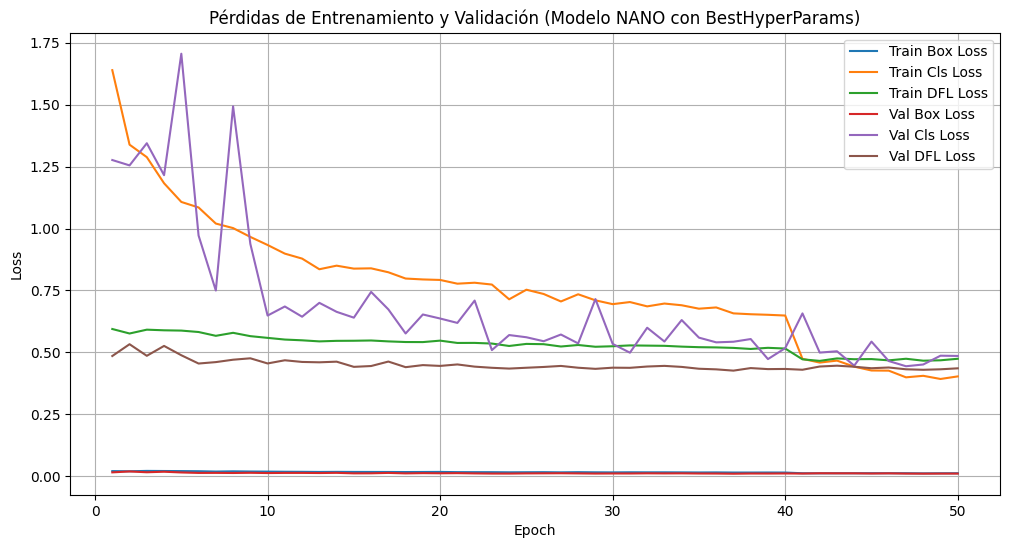

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta al archivo de métricas
metrics_path = "/content/runs/detect/train8/results.csv"

# Cargar el archivo CSV
try:
    df = pd.read_csv(metrics_path)
    print("Archivo de resultados cargado correctamente.")
except FileNotFoundError:
    print(f"Archivo no encontrado en: {metrics_path}")
    raise

# Mostrar las columnas disponibles
print(" Columnas disponibles:", df.columns.tolist())

# Diccionario de nombres esperados y sus etiquetas bonitas
loss_columns = {
    "train/box_loss": "Train Box Loss",
    "train/cls_loss": "Train Cls Loss",
    "train/dfl_loss": "Train DFL Loss",
    "val/box_loss": "Val Box Loss",
    "val/cls_loss": "Val Cls Loss",
    "val/dfl_loss": "Val DFL Loss"
}

# Filtrar las que sí existen
available_losses = {k: v for k, v in loss_columns.items() if k in df.columns}

# Verificar si se encontró alguna pérdida
if not available_losses:
    print("No se encontraron columnas de pérdida conocidas.")
else:
    # Graficar
    plt.figure(figsize=(12, 6))
    for col, label in available_losses.items():
        plt.plot(df["epoch"], df[col], label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Pérdidas de Entrenamiento y Validación (Modelo NANO con BestHyperParams)")
    plt.legend()
    plt.grid(True)
    plt.show()




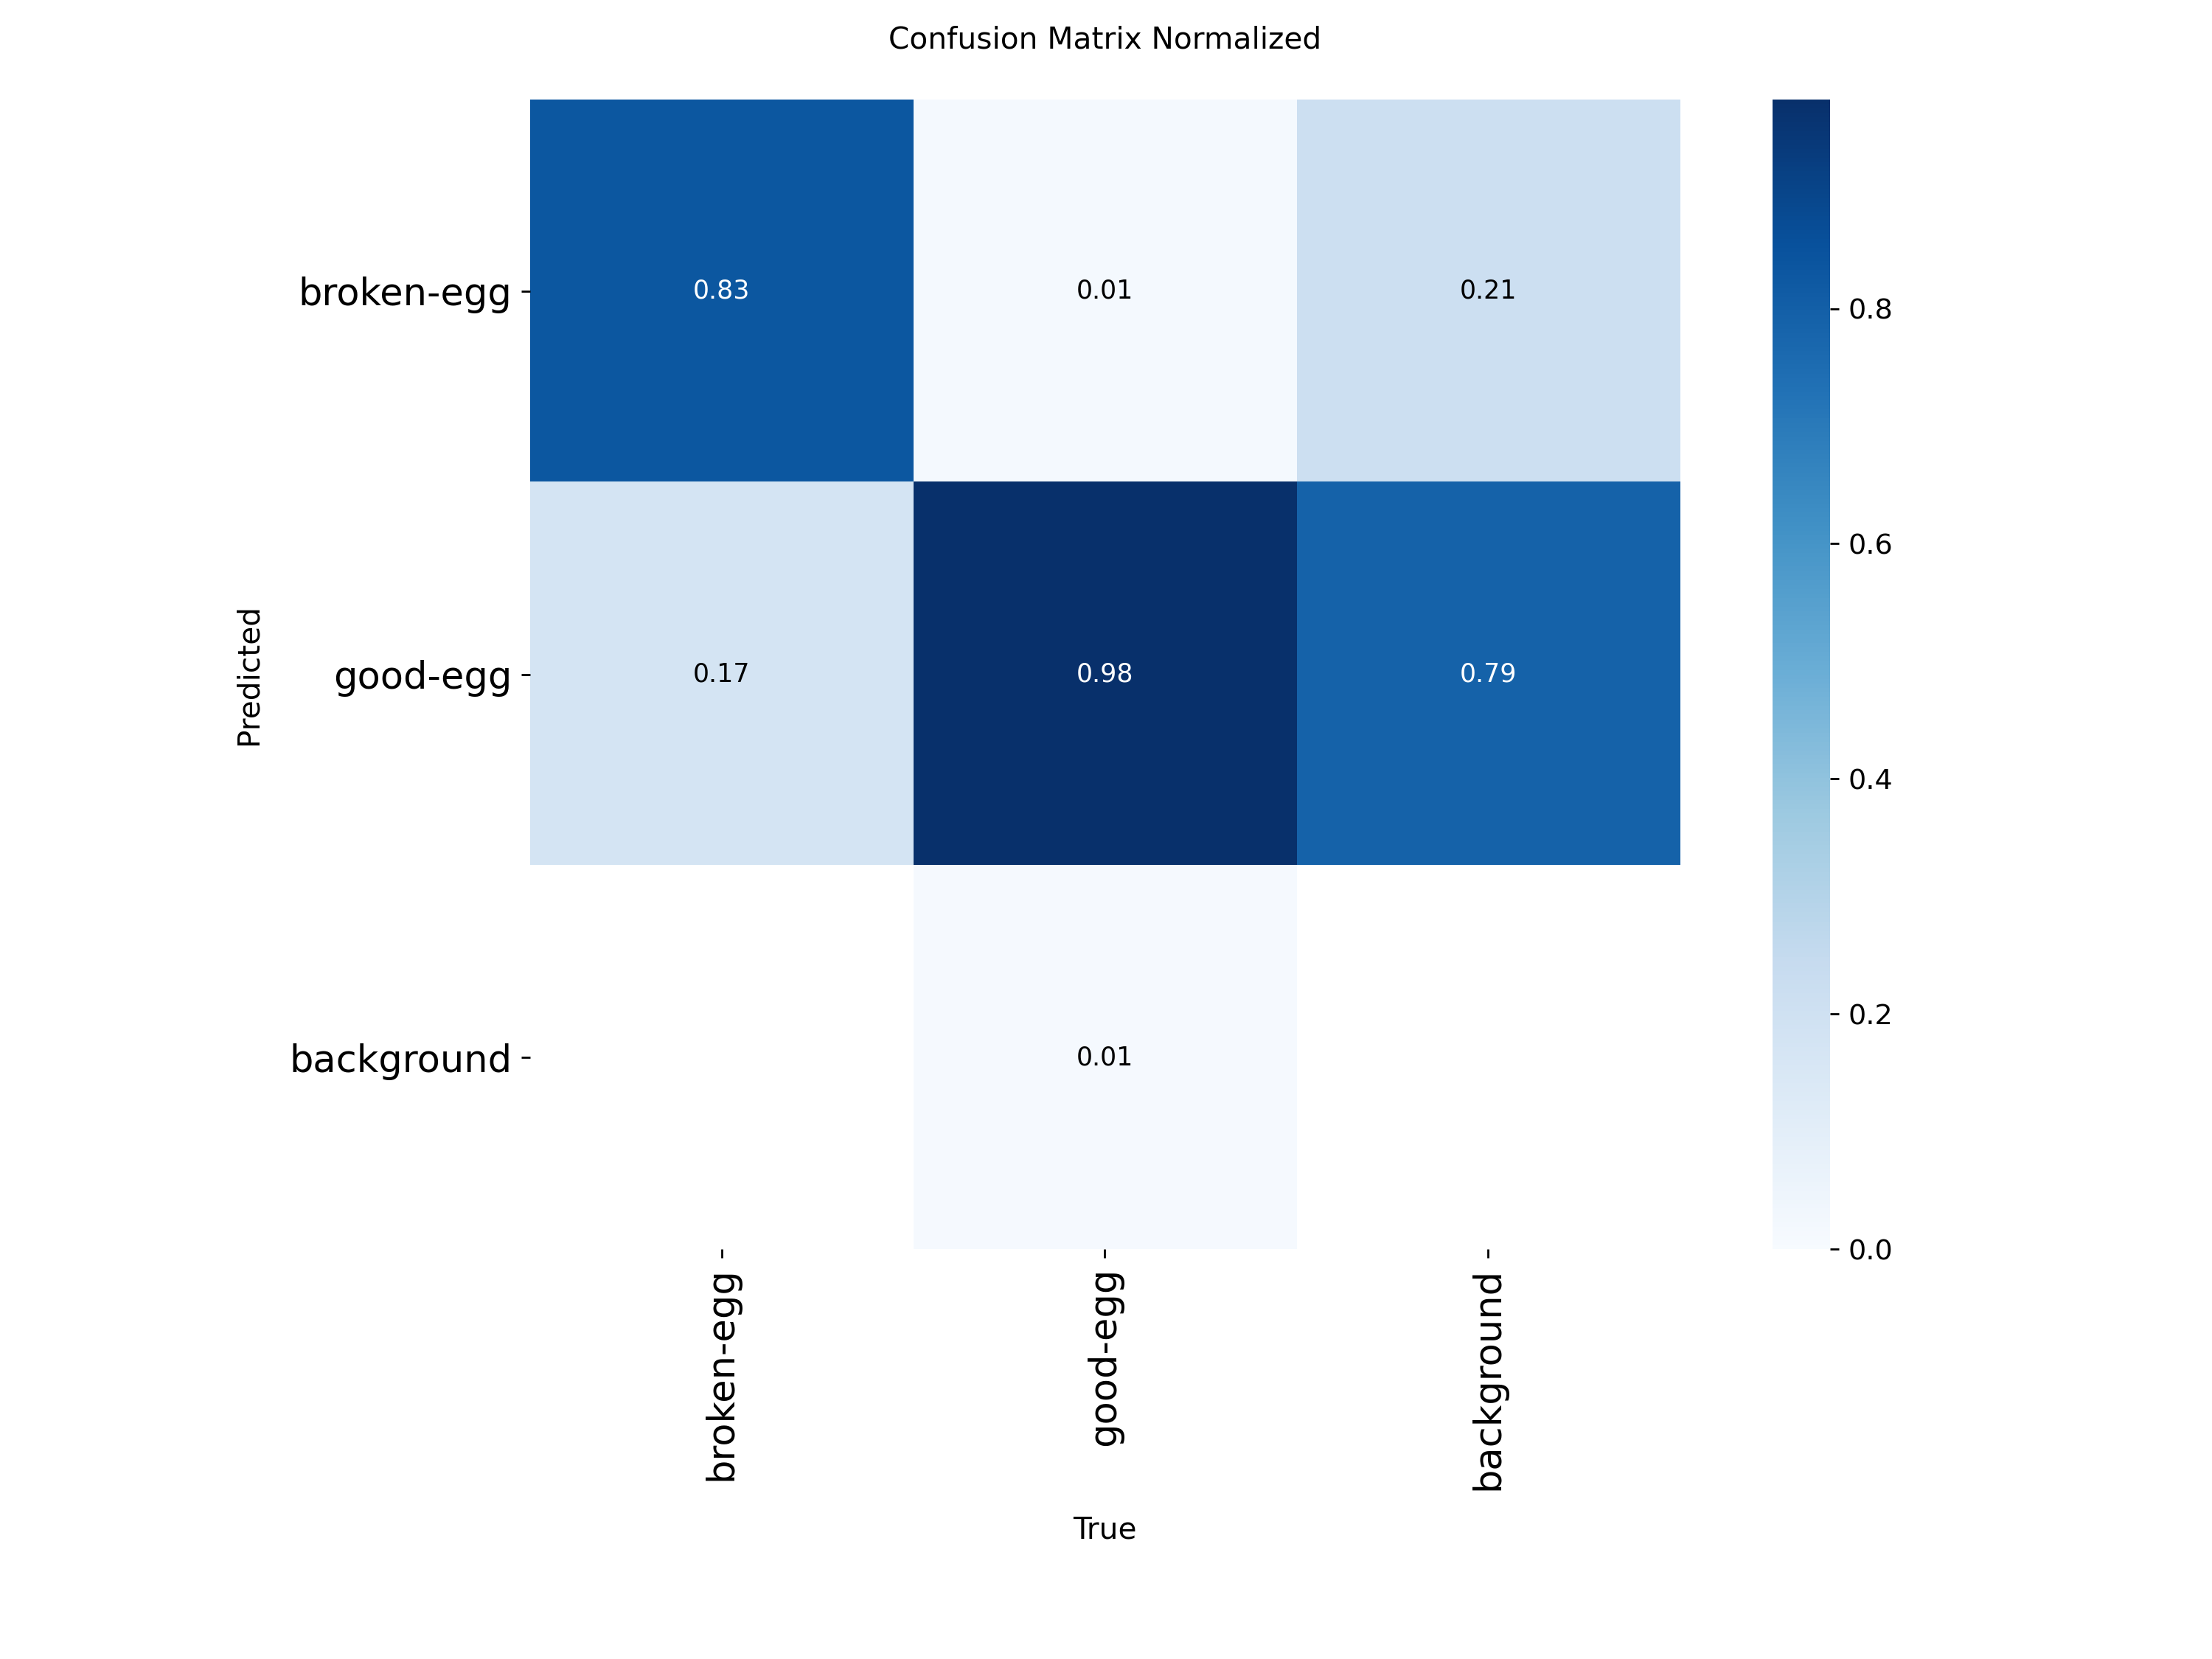

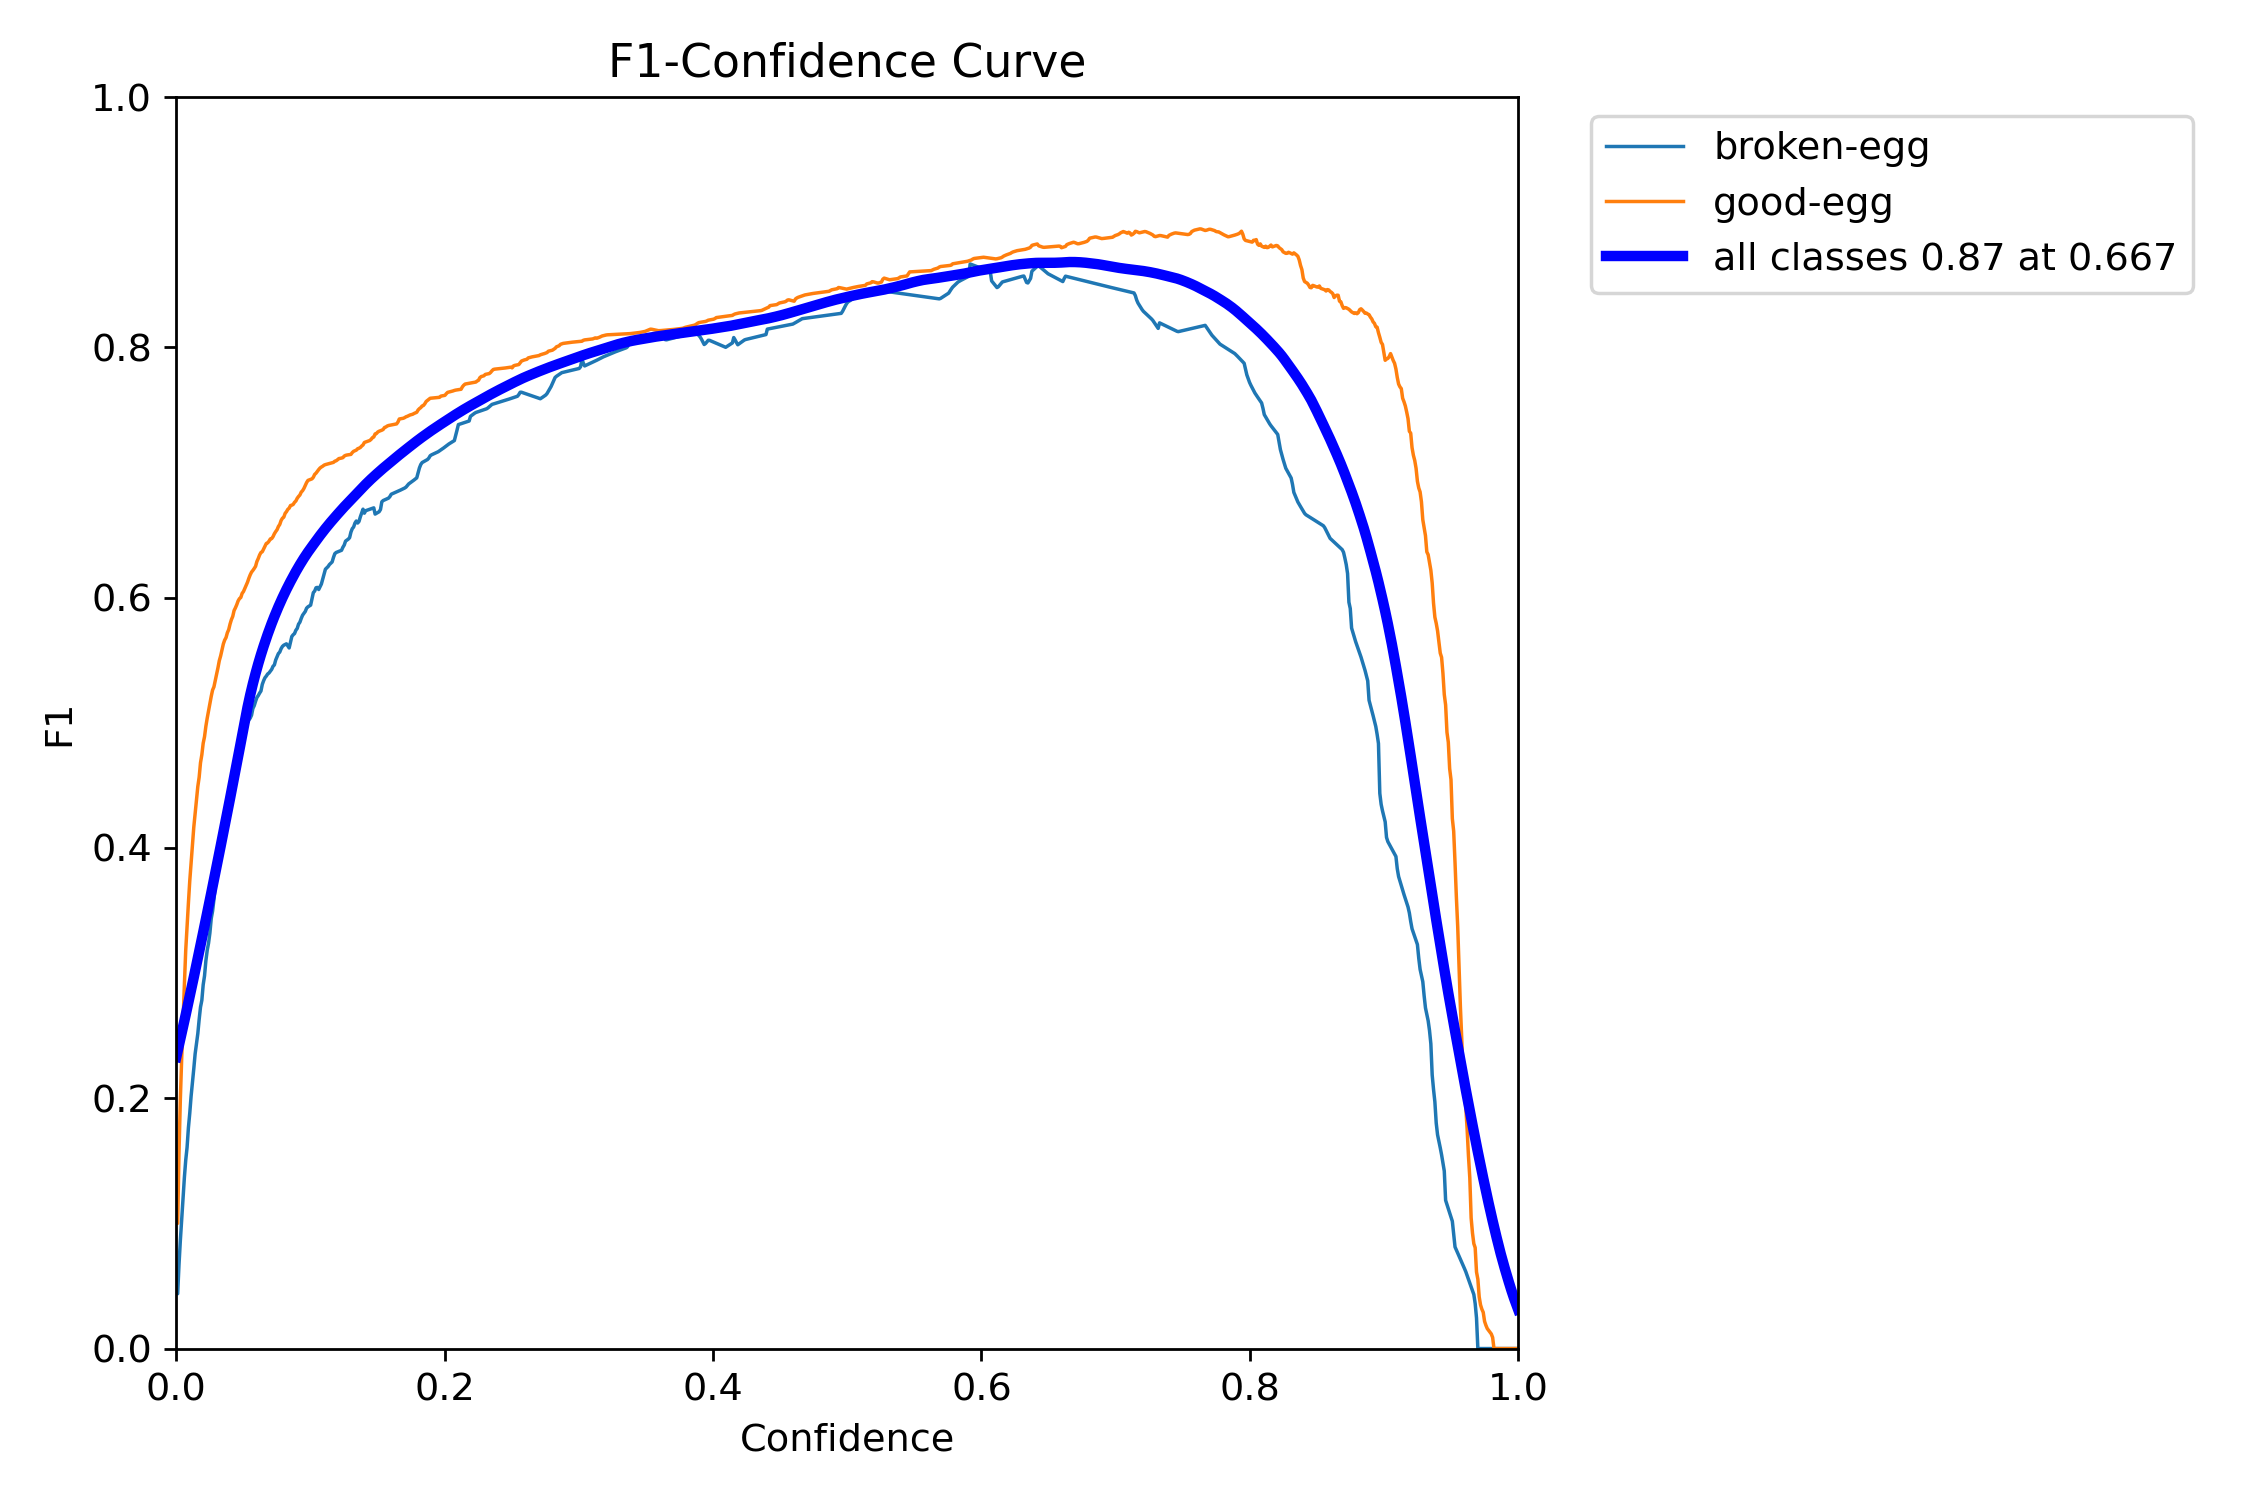

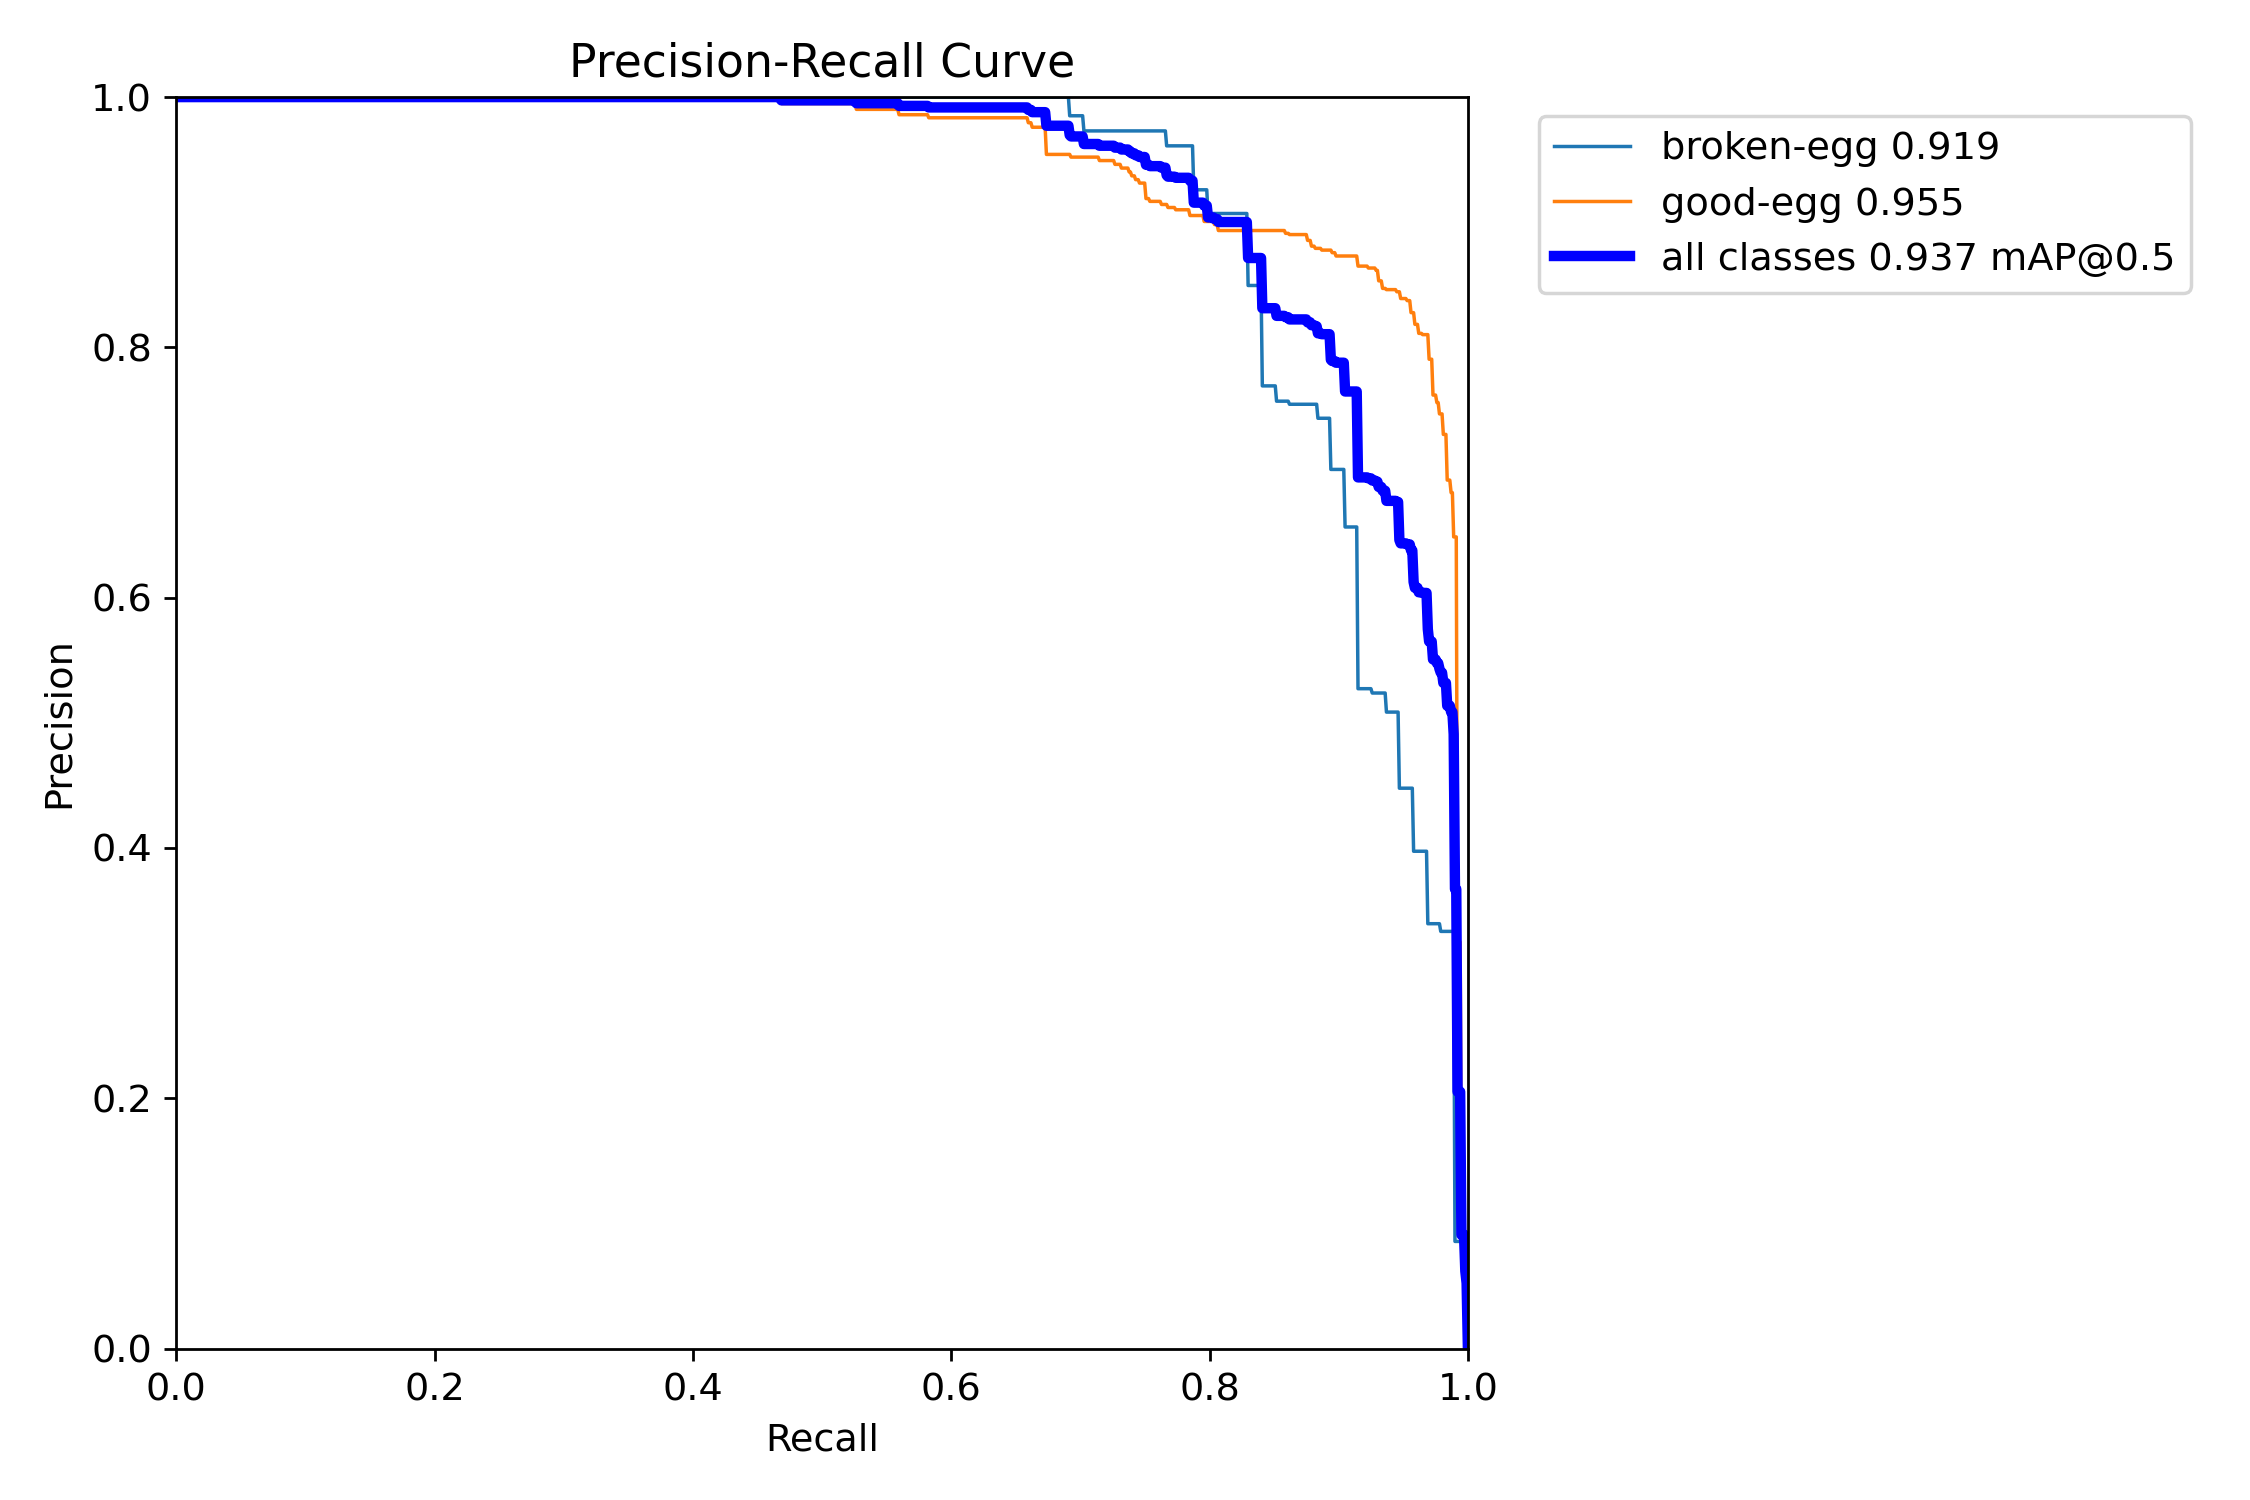

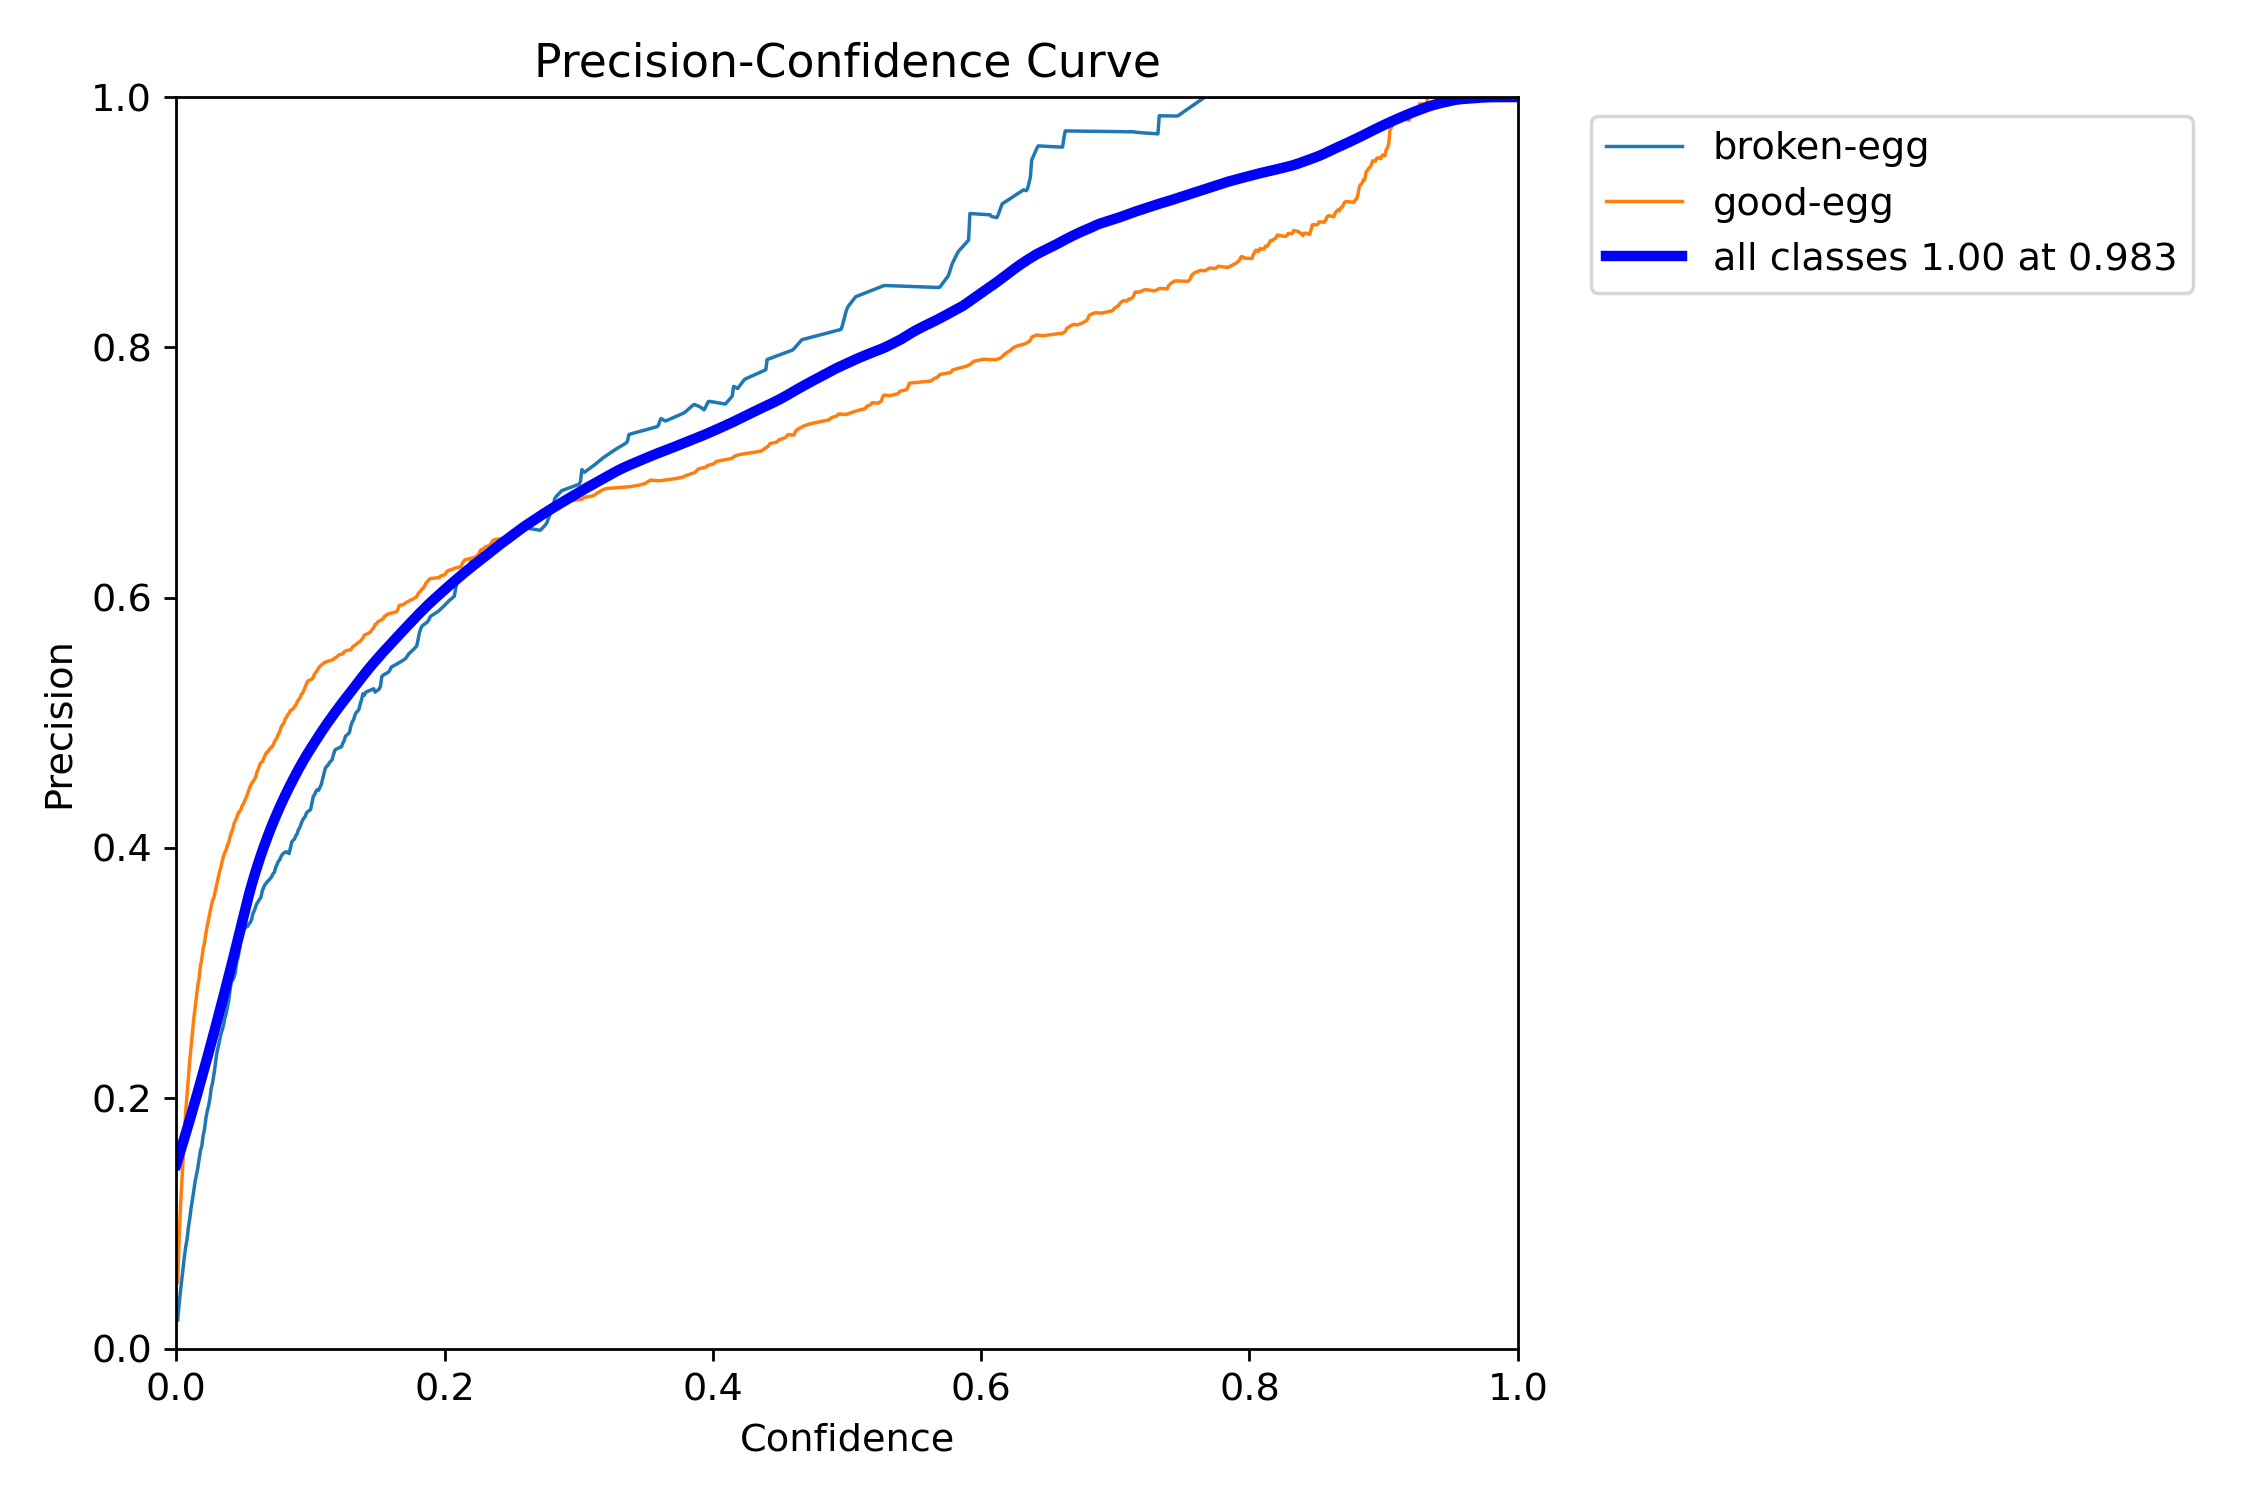

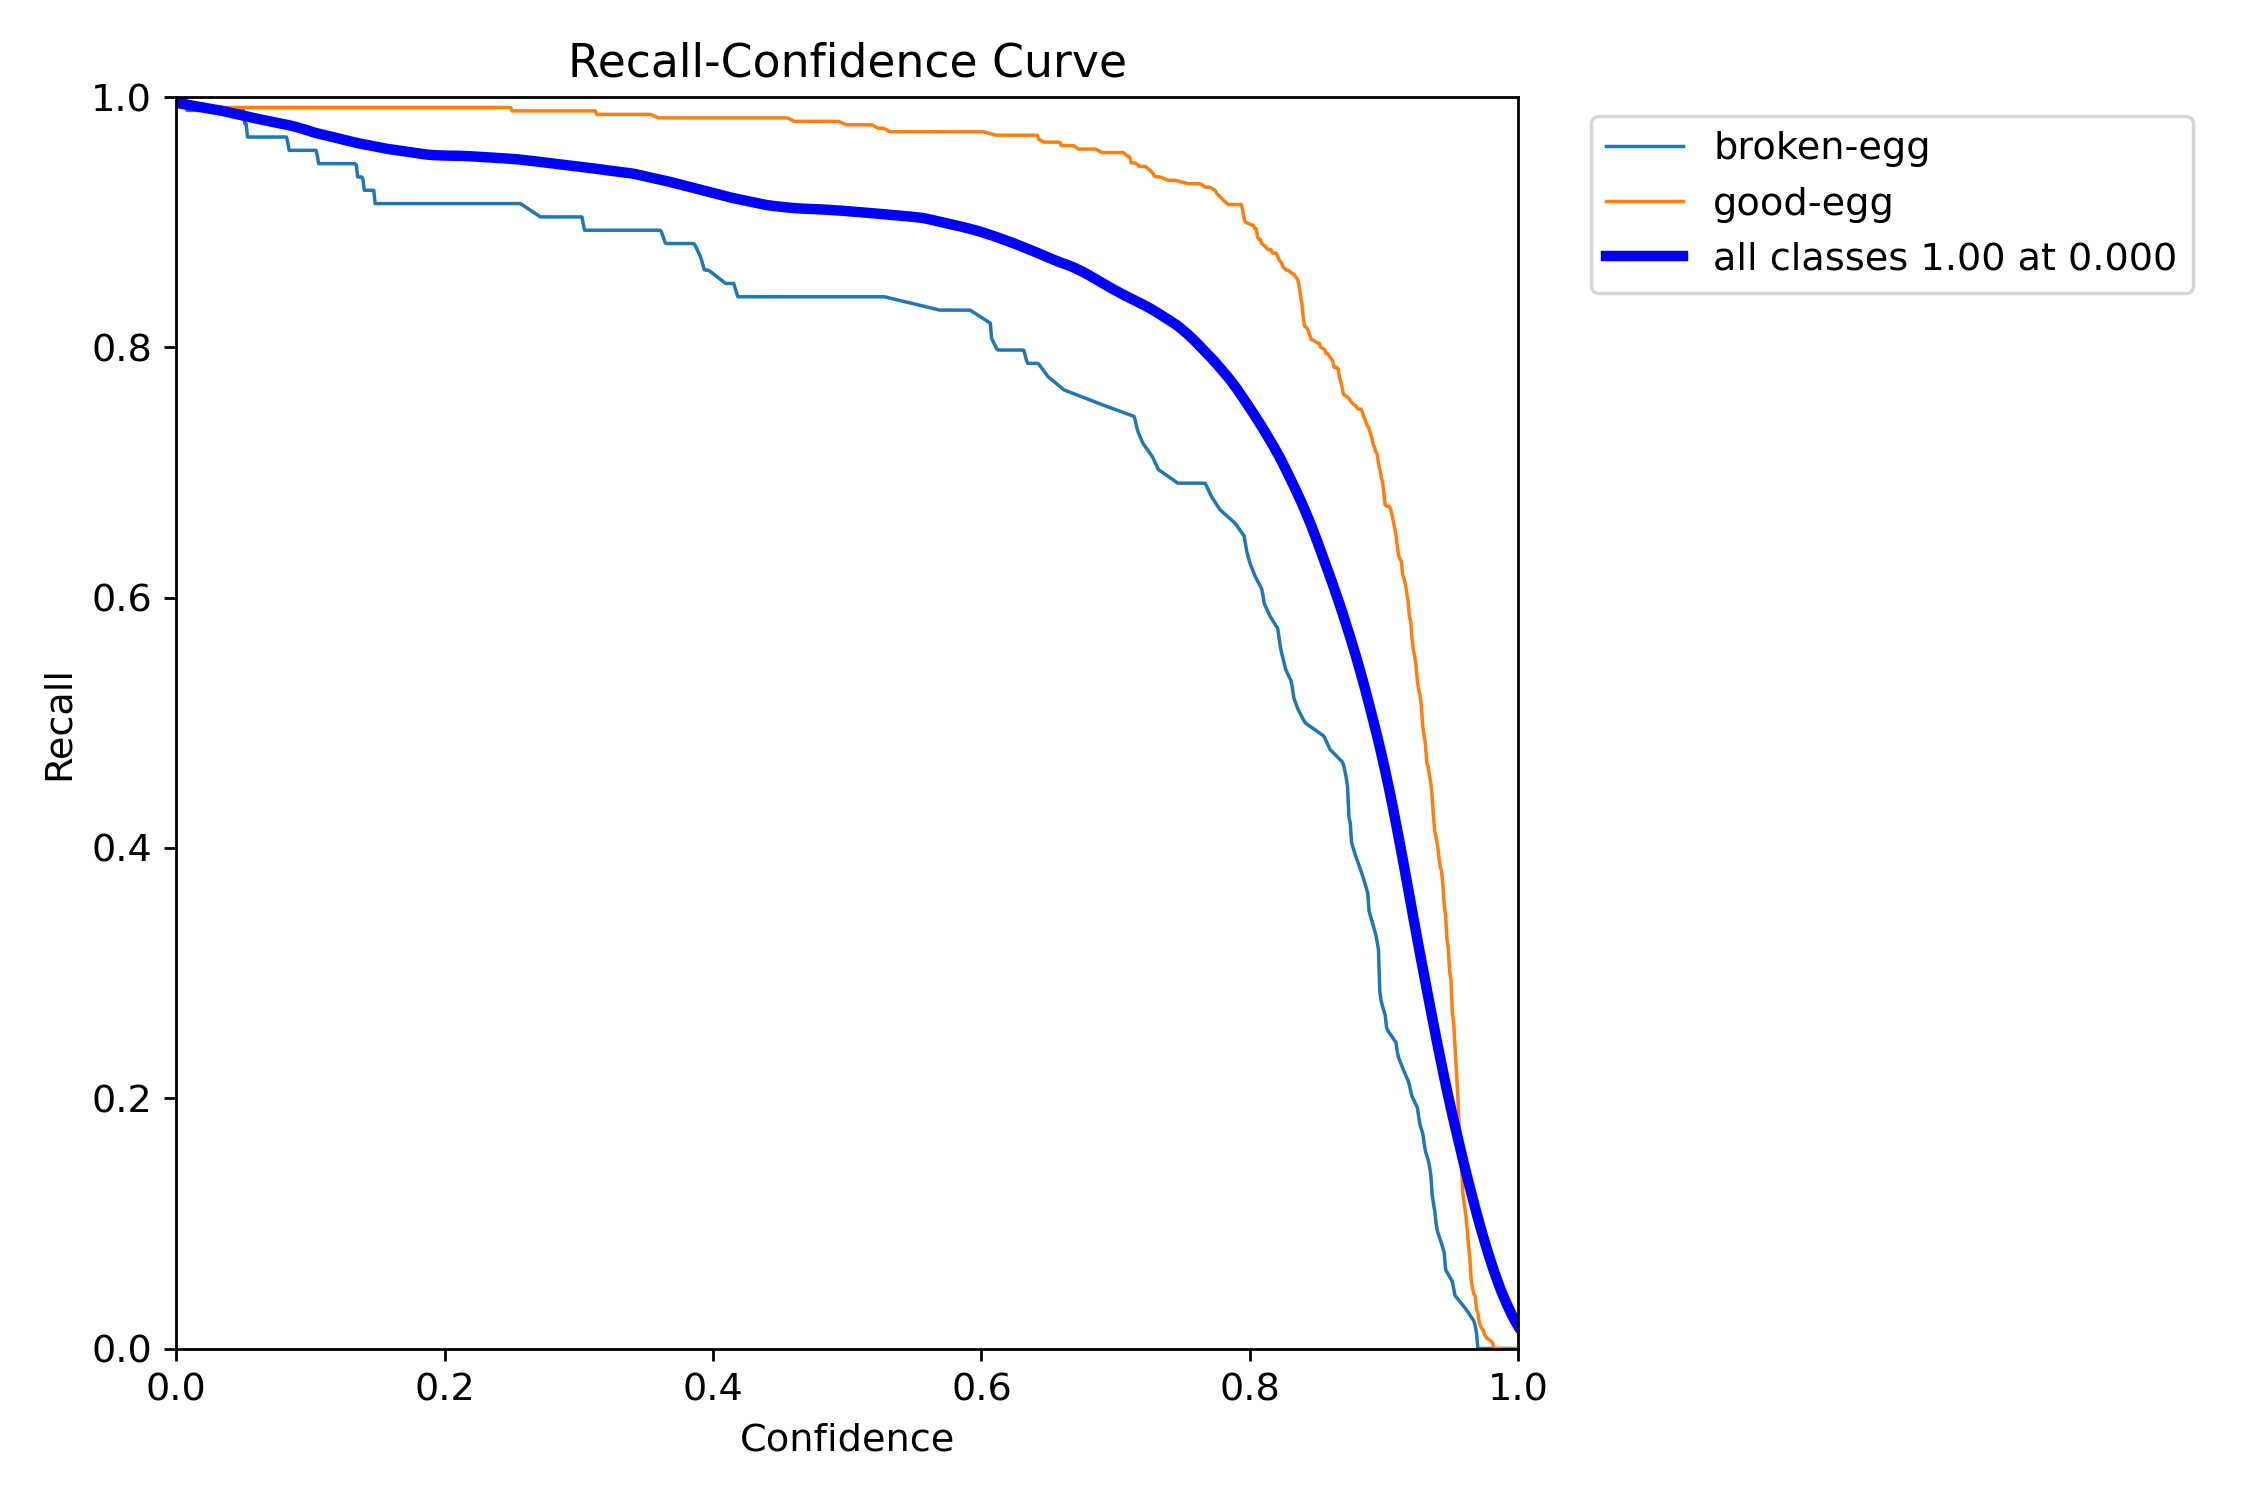

In [ ]:
import os
from IPython.display import Image, display

val_dir = "/content/runs/detect/train83"
for fname in ["confusion_matrix_normalized.png", "F1_curve.png", "PR_curve.png", "P_curve.png","R_curve.png"]:
    fpath = os.path.join(val_dir, fname)
    if os.path.exists(fpath):
        display(Image(filename=fpath,width=1000))
    else:
        print(f" {fname} no encontrado.")


# **Entrenar al Modelo (Usando los mejores hiperparametros y Knowledge distillation)**

In [ ]:
!pip install ultralytics

In [ ]:
import os
import torch
from ultralytics import YOLO
import yaml
from tqdm import tqdm
from pathlib import Path
import shutil
import cv2
from glob import glob

# Configuraciones del usuario
teacher_path = '/content/Modelito_v11_best.pt'
student_model_name = 'yolov8n.pt'
data_path = '/content/dataset/data.yaml'
best_hyp_yaml_path = 'best_hyp.yaml'
IMG_SIZE = 640
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Leer hiperparámetros
with open(best_hyp_yaml_path, 'r') as f:
    hp = yaml.safe_load(f)

def three_stage_distillation(hp):
    print("=== Destilación en tres etapas iniciada ===")

    # Cargar modelos
    teacher = YOLO(teacher_path)
    student = YOLO(student_model_name)

    # === ETAPA 1: Entrenamiento inicial ===
    print("\n==== ETAPA 1: Entrenamiento inicial con data augmentation ====")
    student.train(
        data=data_path,
        epochs=4,
        imgsz=IMG_SIZE,
        batch=16,
        device=DEVICE,
        warmup_epochs=hp['warmup_epochs'],
        momentum=hp['momentum'],
        weight_decay=hp['weight_decay'],
        lr0=hp['lr0'],
        augment=True,
        mixup=0.1,
        copy_paste=0.1,
        name='student_stage1'
    )

    # === ETAPA 2: Knowledge Distillation ===
    print("\n==== ETAPA 2: Knowledge Distillation ====")
    teacher_data_yaml = create_teacher_dataset(teacher, data_path, hp['conf_threshold'])

    student_stage1_path = Path('runs/detect/student_stage1/weights/best.pt')
    if not student_stage1_path.exists():
        student_stage1_path = Path('runs/detect/student_stage1/weights/last.pt')
    student_stage2 = YOLO(str(student_stage1_path))
    student_stage2.train(
        data=teacher_data_yaml,
        epochs=int(hp['epochs'] / 2),
        imgsz=IMG_SIZE,
        batch=hp['batch_size'],
        device=DEVICE,
        lr0=hp['learning_rate'] / 2,
        weight_decay=hp['weight_decay'] * 2,
        name='student_stage2'
    )

    # === ETAPA 3: Fine-tuning ===
    print("\n==== ETAPA 3: Fine-tuning final ====")
    student_stage2_path = Path('runs/detect/student_stage2/weights/best.pt')
    if not student_stage2_path.exists():
        student_stage2_path = Path('runs/detect/student_stage2/weights/last.pt')
    student_final = YOLO(str(student_stage2_path))
    student_final.train(
        data=data_path,
        epochs=20,
        imgsz=IMG_SIZE,
        batch=hp['batch_size'],
        device=DEVICE,
        lr0=hp['learning_rate'] / 10,
        weight_decay=hp['weight_decay'] * 1.5,
        name='student_final'
    )

    return student_final


def create_teacher_dataset(teacher, original_data_yaml, conf_threshold=0.25, min_bbox_size=0.01):
    print(f"Creando dataset anotado por el teacher...")

    # Leer configuración YAML original
    with open(original_data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)

    teacher_dataset_path = '/content/teacher_dataset'
    os.makedirs(f"{teacher_dataset_path}/images", exist_ok=True)
    os.makedirs(f"{teacher_dataset_path}/labels", exist_ok=True)

    train_dir = data_config['train']
    if os.path.exists(os.path.join(train_dir, 'images')):
        train_dir = os.path.join(train_dir, 'images')

    image_patterns = ['*.jpg', '*.png', '*.jpeg']
    train_images = []
    for pattern in image_patterns:
        train_images.extend(glob(os.path.join(train_dir, '**', pattern), recursive=True))

    if not train_images:
        raise RuntimeError("No se encontraron imágenes de entrenamiento.")

    print(f"Procesando {len(train_images)} imágenes...")

    teacher.model.eval()

    total_detections = 0
    filtered_detections = 0

    with torch.no_grad():
        for img_path in tqdm(train_images):
            img_name = os.path.basename(img_path)
            base_name = os.path.splitext(img_name)[0]
            new_img_path = os.path.join(teacher_dataset_path, 'images', img_name)
            shutil.copy(img_path, new_img_path)

            img = cv2.imread(img_path)
            if img is None:
                continue

            height, width = img.shape[:2]
            results = teacher(img_path, verbose=False)

            label_path = os.path.join(teacher_dataset_path, 'labels', f"{base_name}.txt")
            with open(label_path, 'w') as f:
                for result in results:
                    for box in result.boxes:
                        cls = int(box.cls.item())
                        x, y, w, h = box.xywhn[0].tolist()
                        conf = box.conf.item()
                        total_detections += 1
                        if conf > conf_threshold and w * h > min_bbox_size:
                            filtered_detections += 1
                            f.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    teacher_data_yaml = os.path.join(teacher_dataset_path, 'data.yaml')
    data_config['train'] = os.path.join(teacher_dataset_path, 'images')
    data_config['val'] = data_config.get('val', data_config.get('test'))

    with open(teacher_data_yaml, 'w') as f:
        yaml.dump(data_config, f)

    print(f"\nTotal detecciones: {total_detections}, después del filtrado: {filtered_detections}")
    return teacher_data_yaml


if __name__ == "__main__":
    print("Ejecutando destilación con hiperparámetros ya optimizados...")
    model = three_stage_distillation(hp)

    # Validación final
    results = model.val()
    print("Resultados finales:", results.box.map50)

    # Guardar modelo
    model.export(format='torchscript', name='student_distilled.pt')
    print("Modelo exportado como 'student_distilled.pt'")


Ejecutando destilación con hiperparámetros ya optimizados...
=== Destilación en tres etapas iniciada ===

==== ETAPA 1: Entrenamiento inicial con data augmentation ====
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=4, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=5.1990052268695206e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.700989461820095, mosaic=1.0, multi_scale=False, name=student_stage16, nbs=64, nms=False, opset=

train: Scanning /content/dataset/train/labels.cache... 1338 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1338/1338 [00:00<?, ?it/s]

train: /content/dataset/train/images/not_damaged_73_jpg.rf.63c2470eca4c3b543666dde723d93b01.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 613.2±224.3 MB/s, size: 39.1 KB)



val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]

Plotting labels to runs/detect/student_stage16/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=5.1990052268695206e-05' and 'momentum=0.700989461820095' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.009507991272050454), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/student_stage16
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4         0G     0.6222      1.827      1.022         88        640: 100%|██████████| 84/84 [19:47<00:00, 14.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:46<00:00, 11.69s/it]

                   all        117        455      0.516      0.606      0.552      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4         0G     0.6418      1.403      1.021         45        640: 100%|██████████| 84/84 [18:54<00:00, 13.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:39<00:00,  9.85s/it]

                   all        117        455      0.562      0.697      0.639      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4         0G     0.6077      1.232      1.003         60        640: 100%|██████████| 84/84 [18:36<00:00, 13.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:37<00:00,  9.38s/it]

                   all        117        455      0.565      0.774      0.708      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4         0G     0.5479      1.086     0.9854         80        640: 100%|██████████| 84/84 [18:40<00:00, 13.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:35<00:00,  8.92s/it]

                   all        117        455      0.824      0.833      0.882      0.814



4 epochs completed in 1.311 hours.
Optimizer stripped from runs/detect/student_stage16/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/student_stage16/weights/best.pt, 6.2MB

Validating runs/detect/student_stage16/weights/best.pt...
Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [01:15<00:00, 18.97s/it]


                   all        117        455      0.872      0.854      0.908      0.832
            broken-egg         63         94      0.914      0.787      0.907       0.84
              good-egg         67        361       0.83       0.92      0.908      0.825
Speed: 3.0ms preprocess, 605.3ms inference, 0.0ms loss, 20.2ms postprocess per image
Results saved to runs/detect/student_stage16

==== ETAPA 2: Knowledge Distillation ====


KeyError: 'conf_threshold'

In [ ]:
model_T = YOLO("/content/Modelito_v11_best.pt")
model_E = YOLO("/content/best_student.pt")
model_NE = YOLO("/content/best_nano_besthyper.pt")

In [ ]:
metrics = model_NE.val()

Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 705.5±241.7 MB/s, size: 41.4 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:29<00:00,  3.70s/it]


                   all        117        455      0.895      0.863      0.937       0.87
            broken-egg         63         94      0.973      0.764      0.919      0.857
              good-egg         67        361      0.817      0.961      0.955      0.883
Speed: 2.0ms preprocess, 237.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val3


In [ ]:
metrics = model_E.val()

Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 571.1±108.0 MB/s, size: 32.3 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:32<00:00,  4.09s/it]


                   all        117        455      0.826      0.831      0.883      0.814
            broken-egg         63         94      0.862      0.734      0.872      0.799
              good-egg         67        361       0.79      0.928      0.893      0.828
Speed: 2.3ms preprocess, 260.0ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/detect/val


In [ ]:
metrics = model_T.val()

Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 775.8±340.5 MB/s, size: 31.0 KB)


val: Scanning /content/dataset/valid/labels.cache... 117 images, 11 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:19<00:00,  9.90s/it]


                   all        117        455      0.928      0.891      0.956       0.93
            broken-egg         63         94      0.983      0.851      0.968      0.944
              good-egg         67        361      0.873      0.931      0.944      0.915
Speed: 2.5ms preprocess, 661.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val2


Archivo de resultados cargado correctamente.
 Columnas disponibles: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


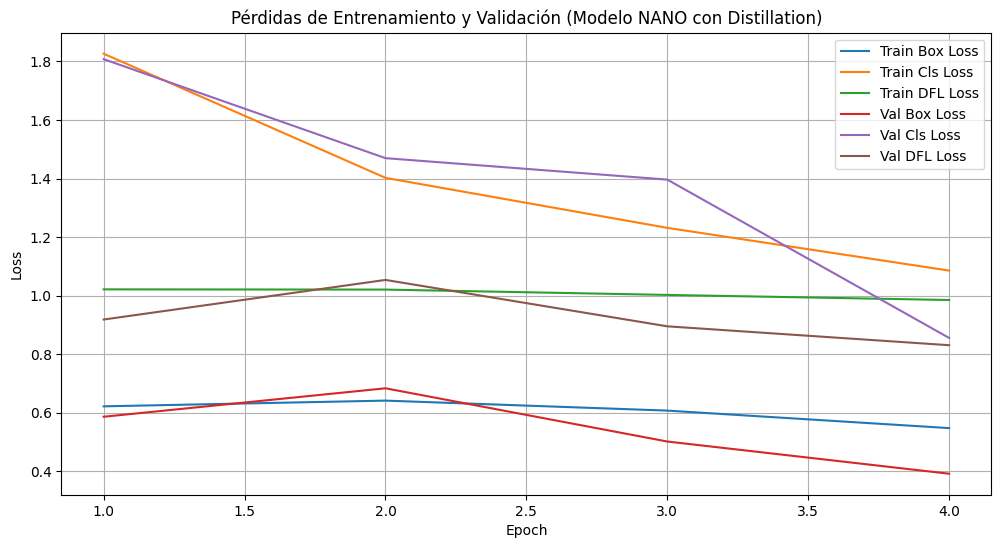

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta al archivo de métricas
metrics_path = "/content/runs/detect/student_stage16/results.csv"

# Cargar el archivo CSV
try:
    df = pd.read_csv(metrics_path)
    print("Archivo de resultados cargado correctamente.")
except FileNotFoundError:
    print(f"Archivo no encontrado en: {metrics_path}")
    raise

# Mostrar las columnas disponibles
print(" Columnas disponibles:", df.columns.tolist())

# Diccionario de nombres esperados y sus etiquetas bonitas
loss_columns = {
    "train/box_loss": "Train Box Loss",
    "train/cls_loss": "Train Cls Loss",
    "train/dfl_loss": "Train DFL Loss",
    "val/box_loss": "Val Box Loss",
    "val/cls_loss": "Val Cls Loss",
    "val/dfl_loss": "Val DFL Loss"
}

# Filtrar las que sí existen
available_losses = {k: v for k, v in loss_columns.items() if k in df.columns}

# Verificar si se encontró alguna pérdida
if not available_losses:
    print("No se encontraron columnas de pérdida conocidas.")
else:
    # Graficar
    plt.figure(figsize=(12, 6))
    for col, label in available_losses.items():
        plt.plot(df["epoch"], df[col], label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Pérdidas de Entrenamiento y Validación (Modelo NANO con Distillation)")
    plt.legend()
    plt.grid(True)
    plt.show()

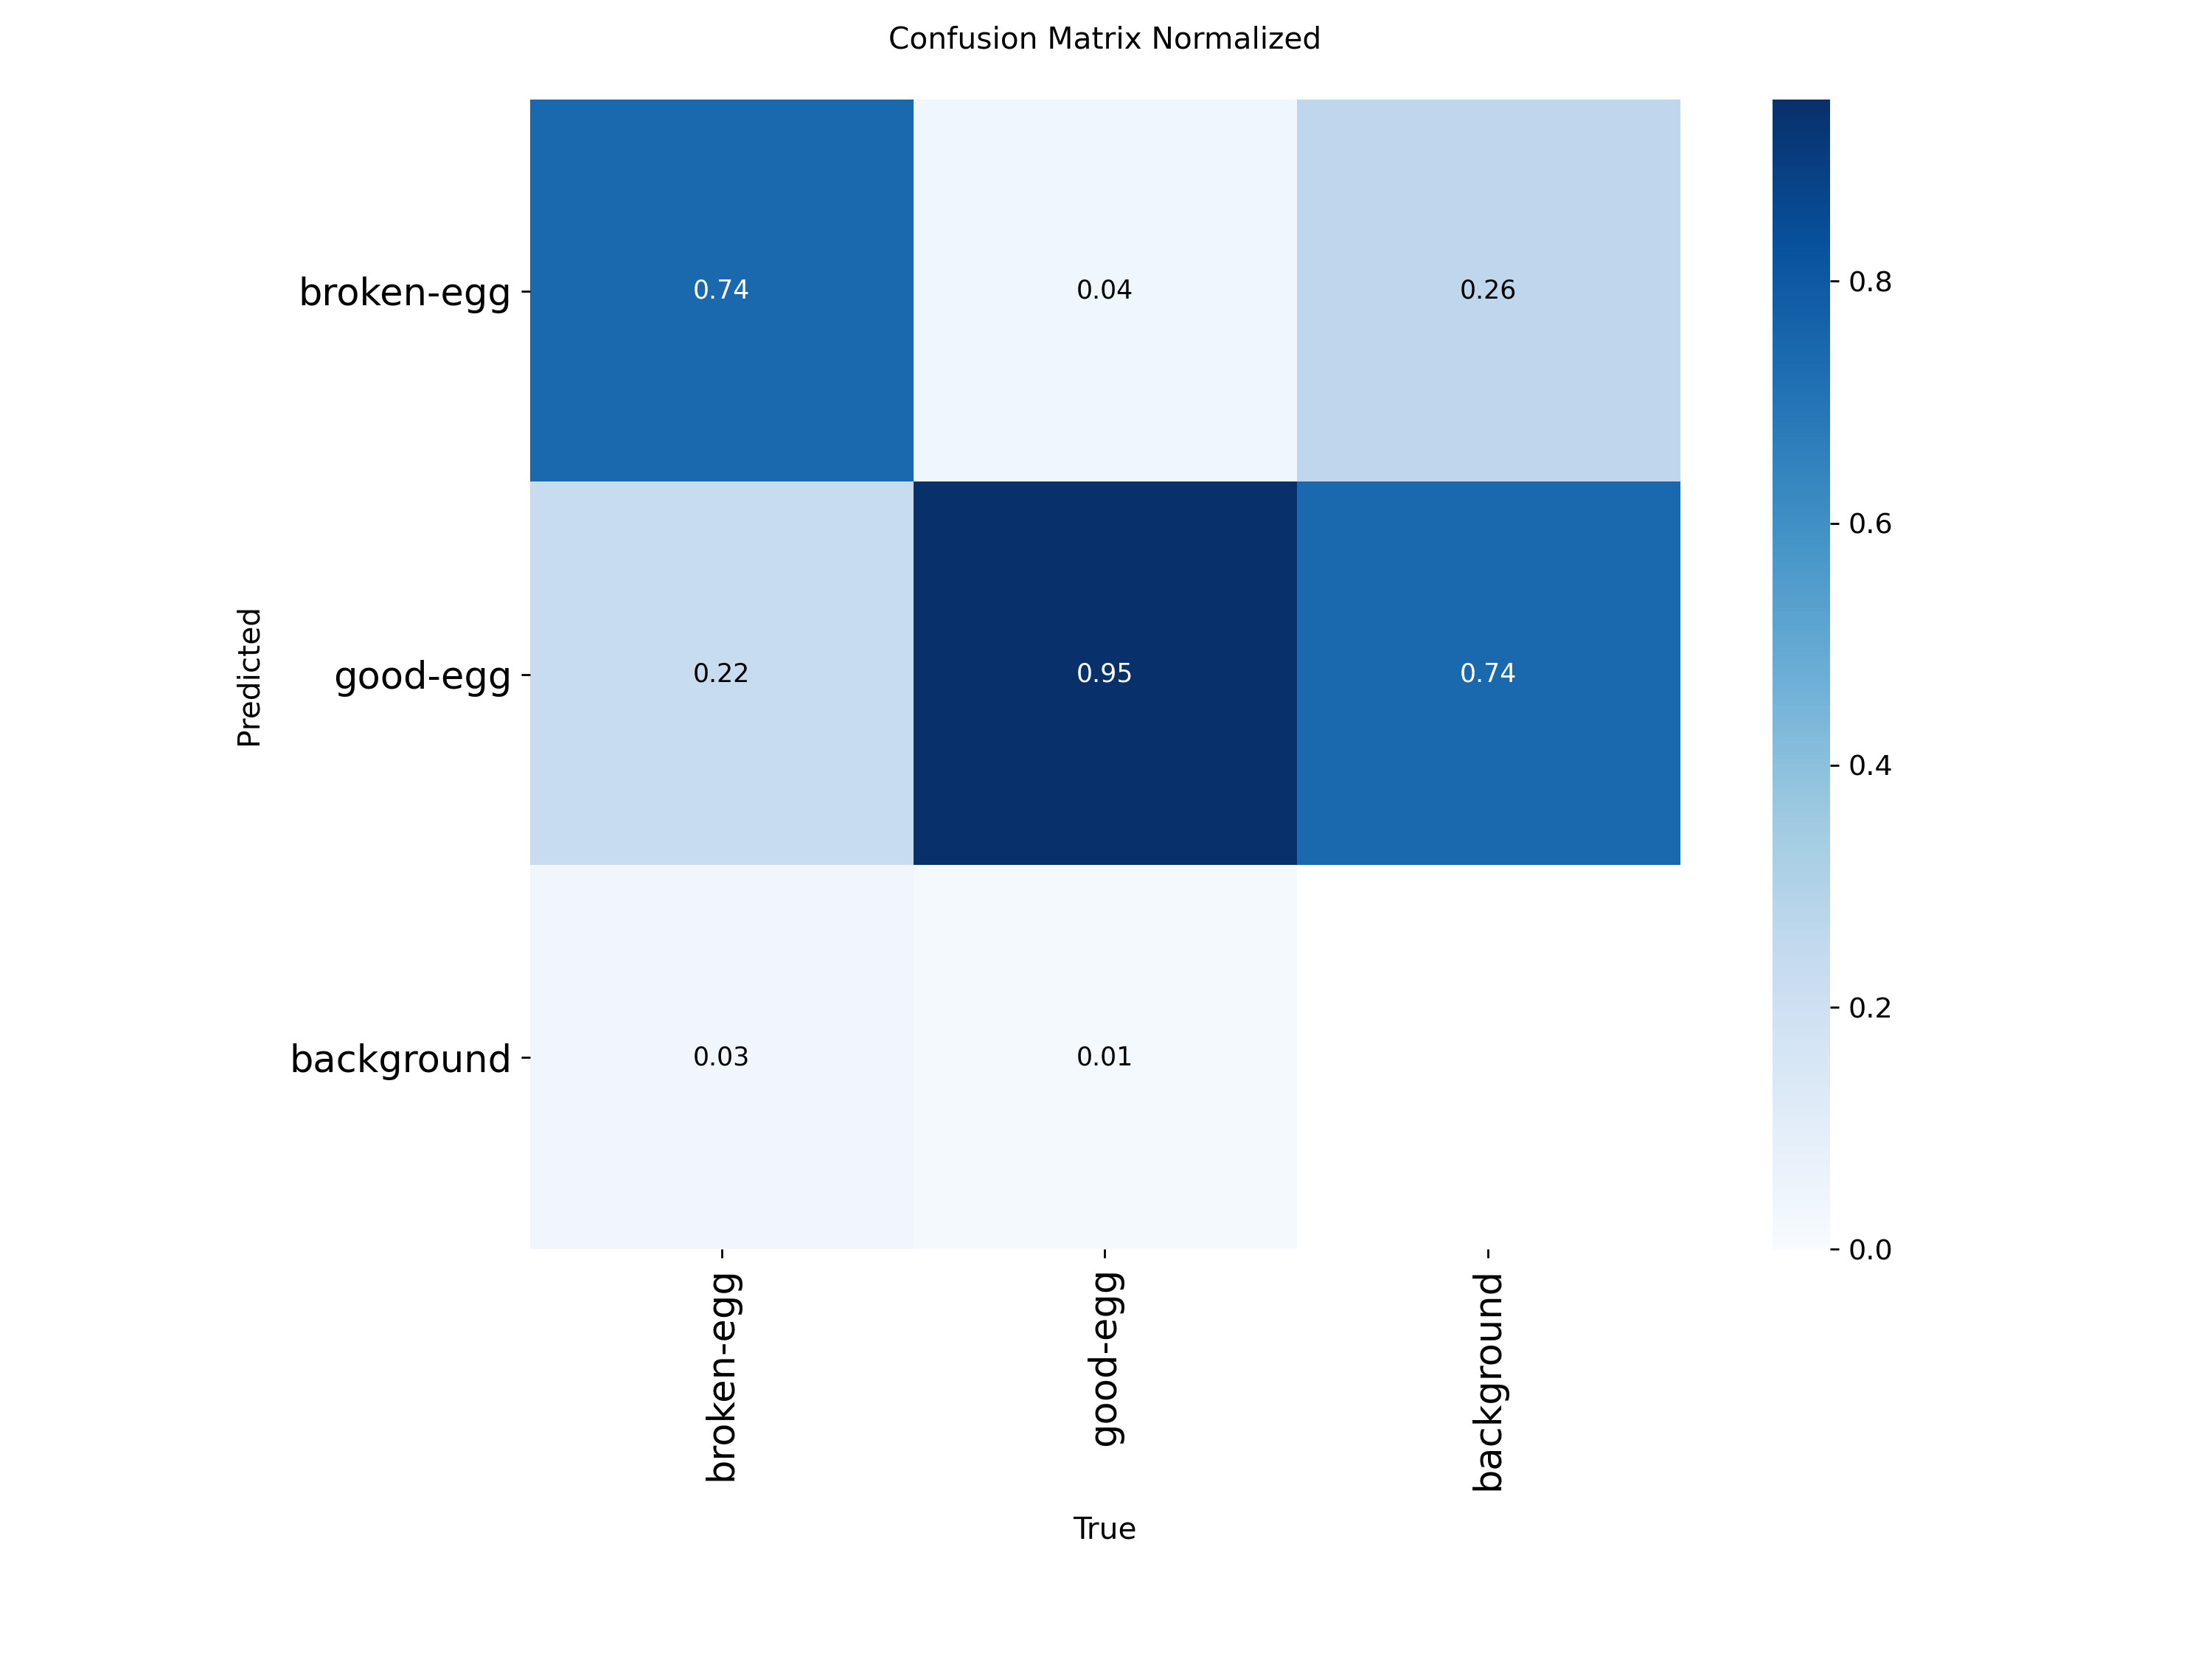

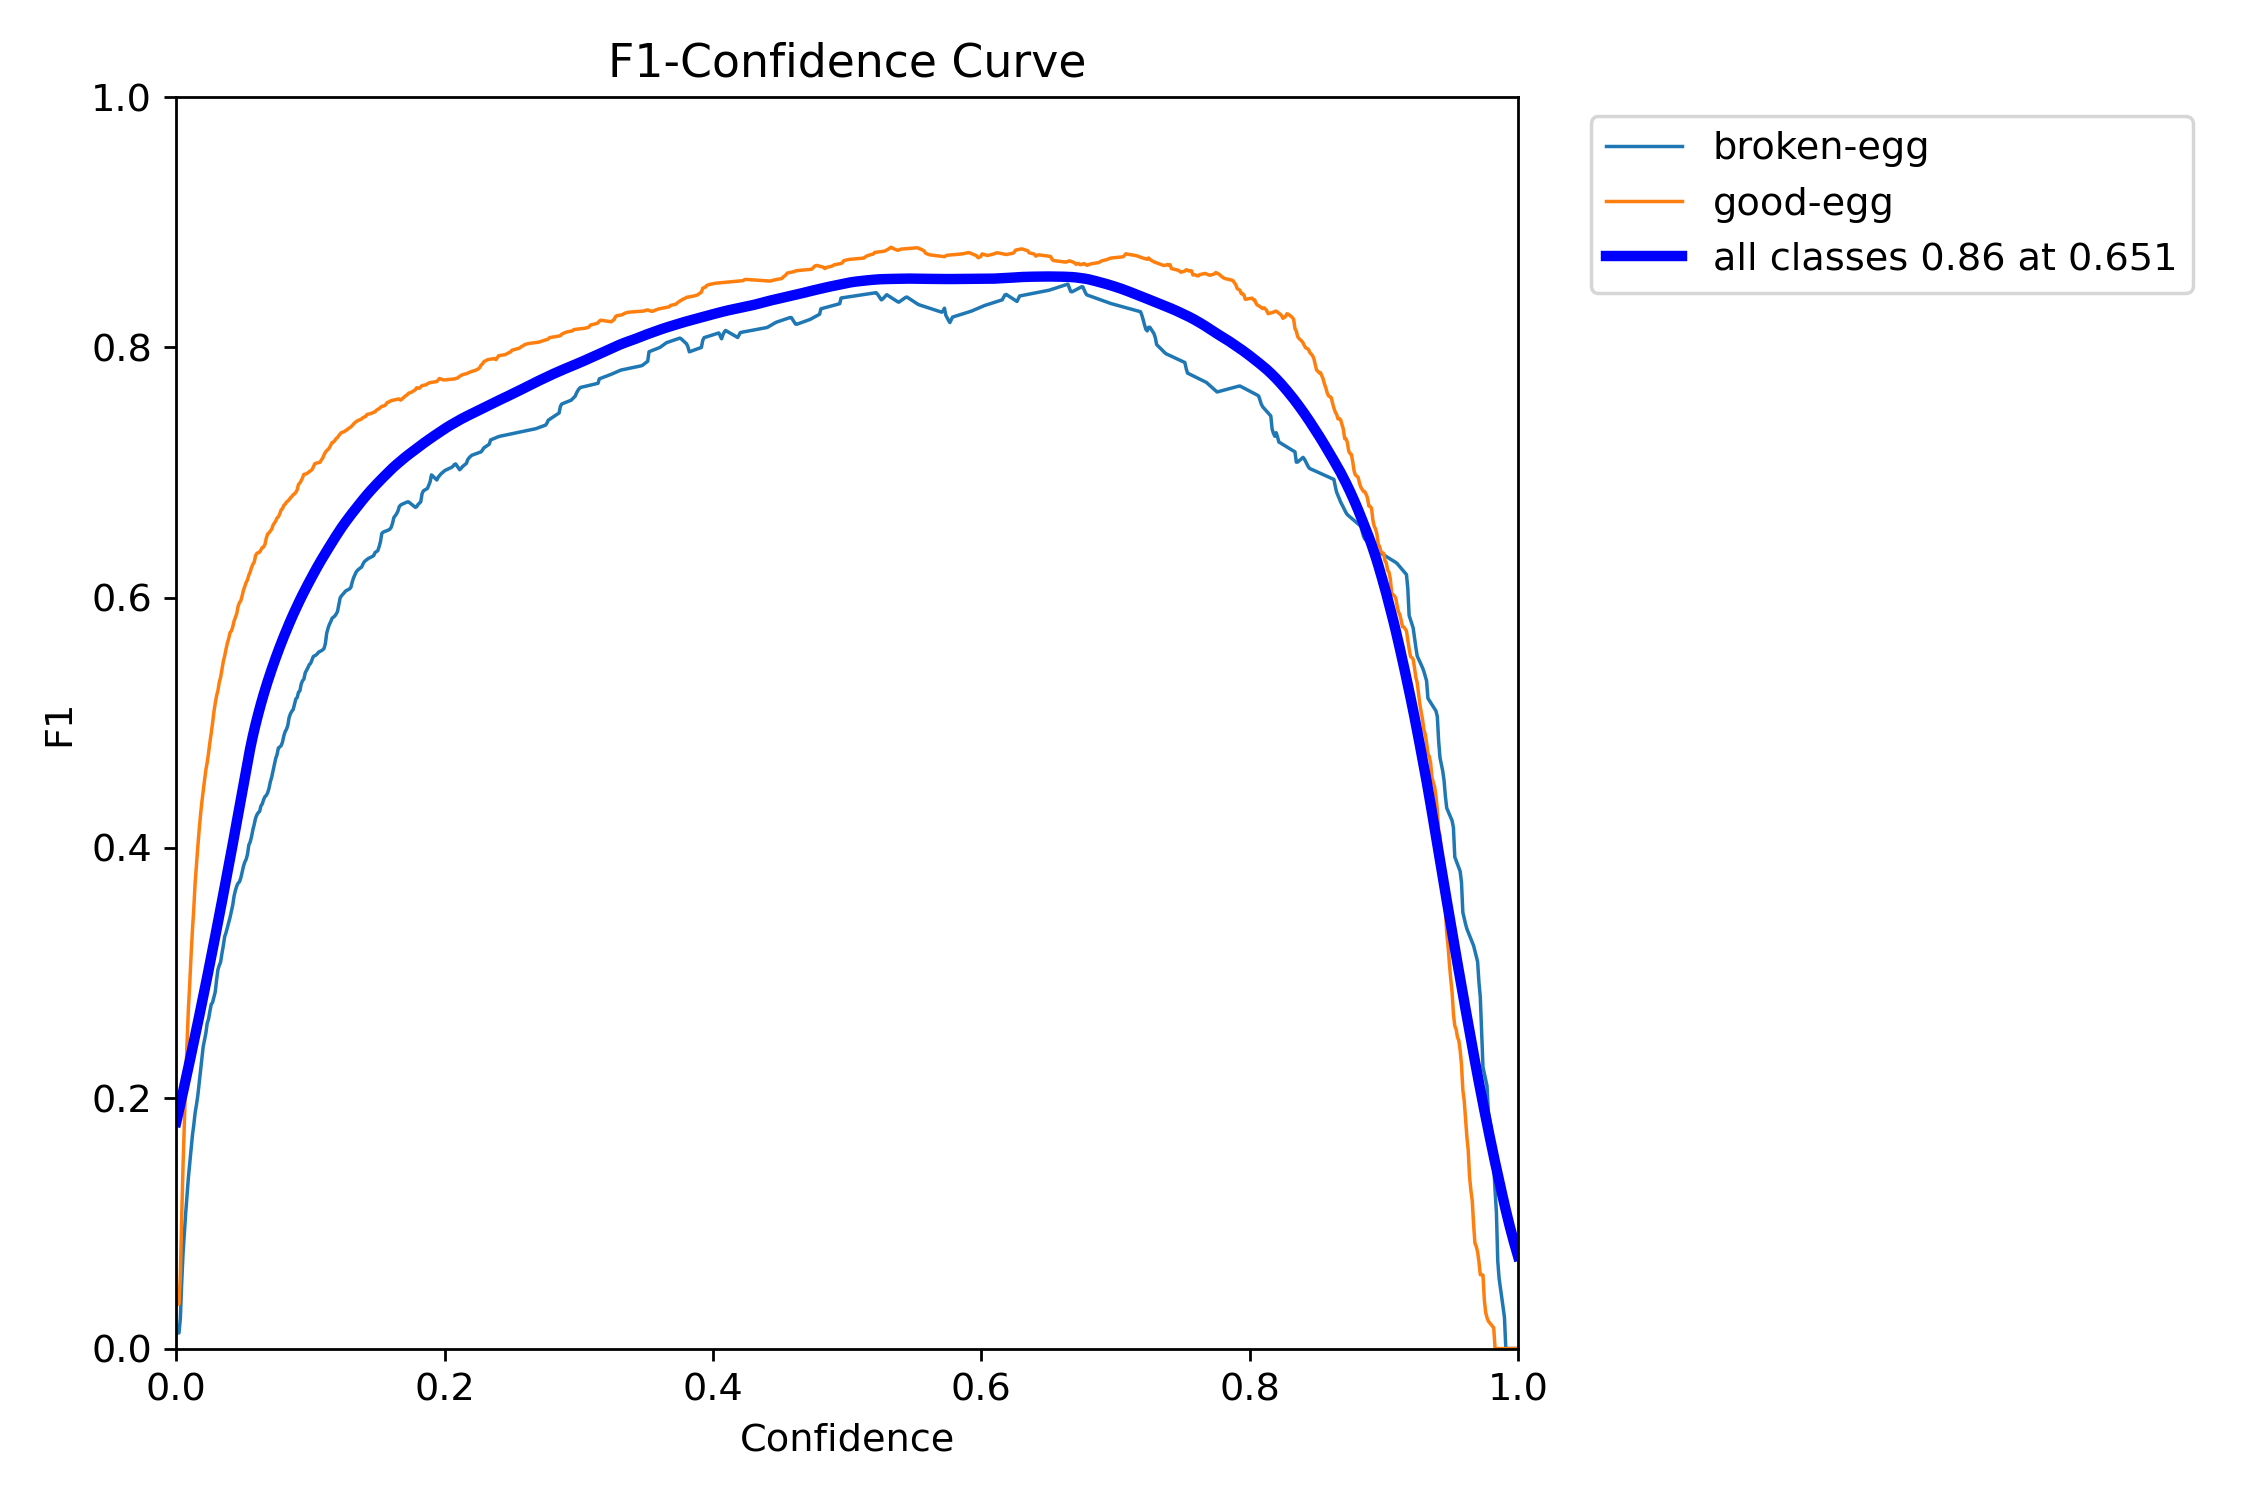

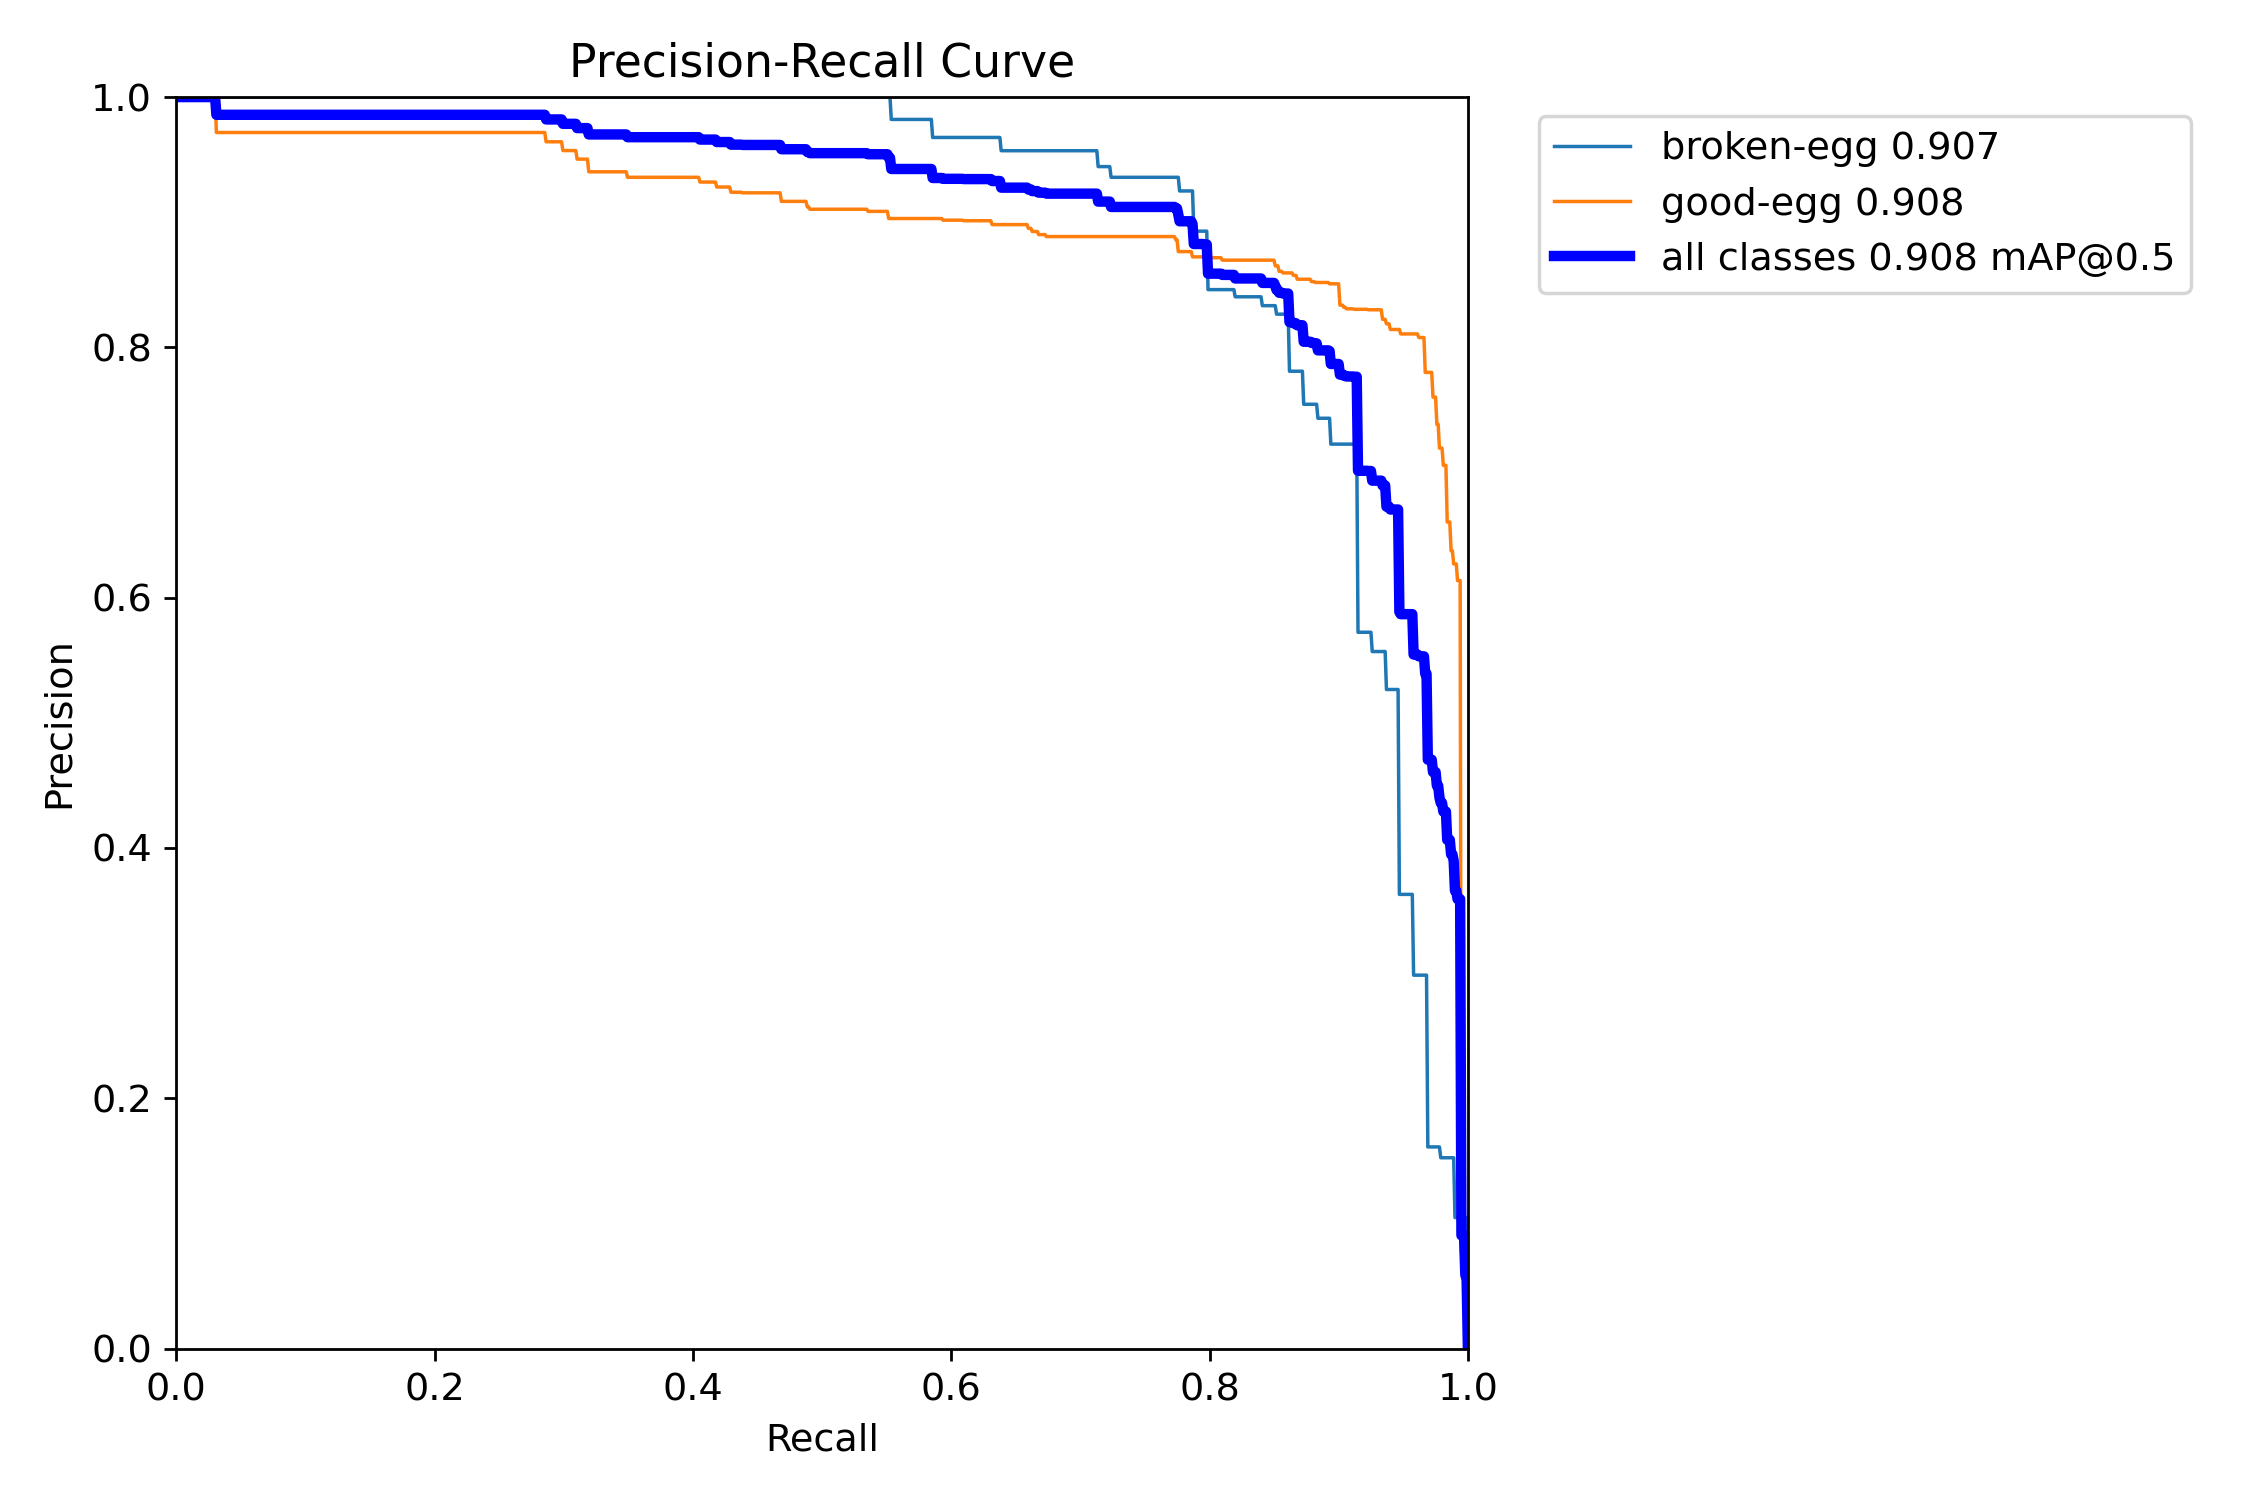

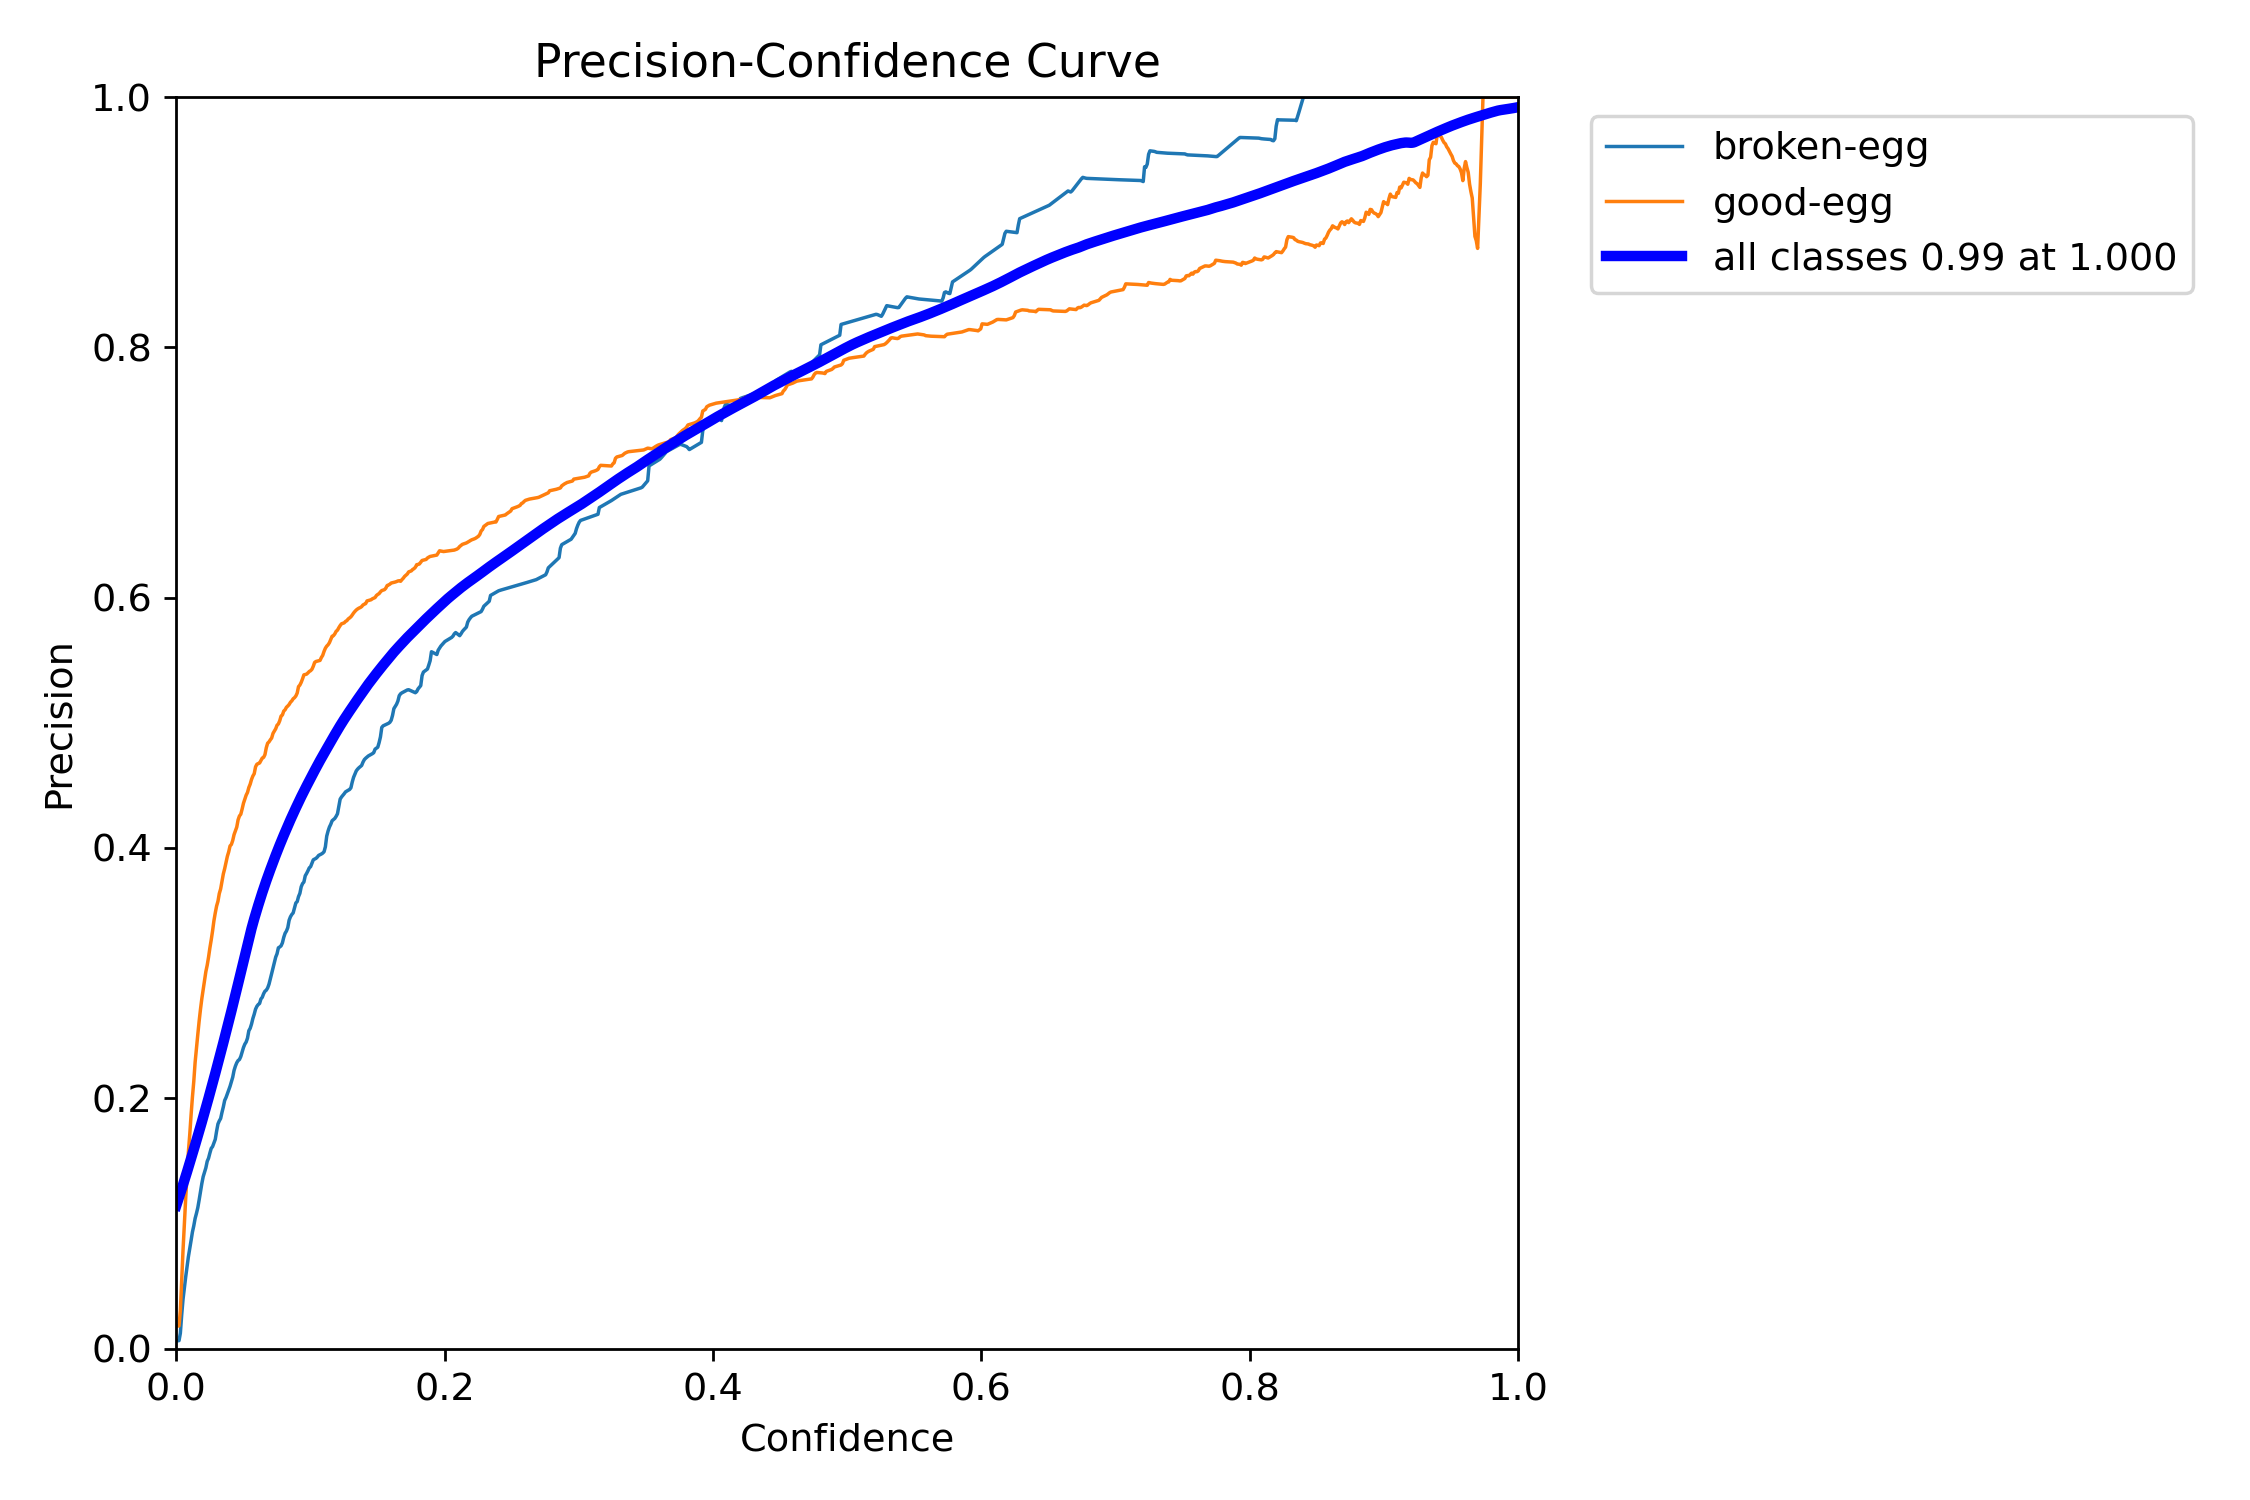

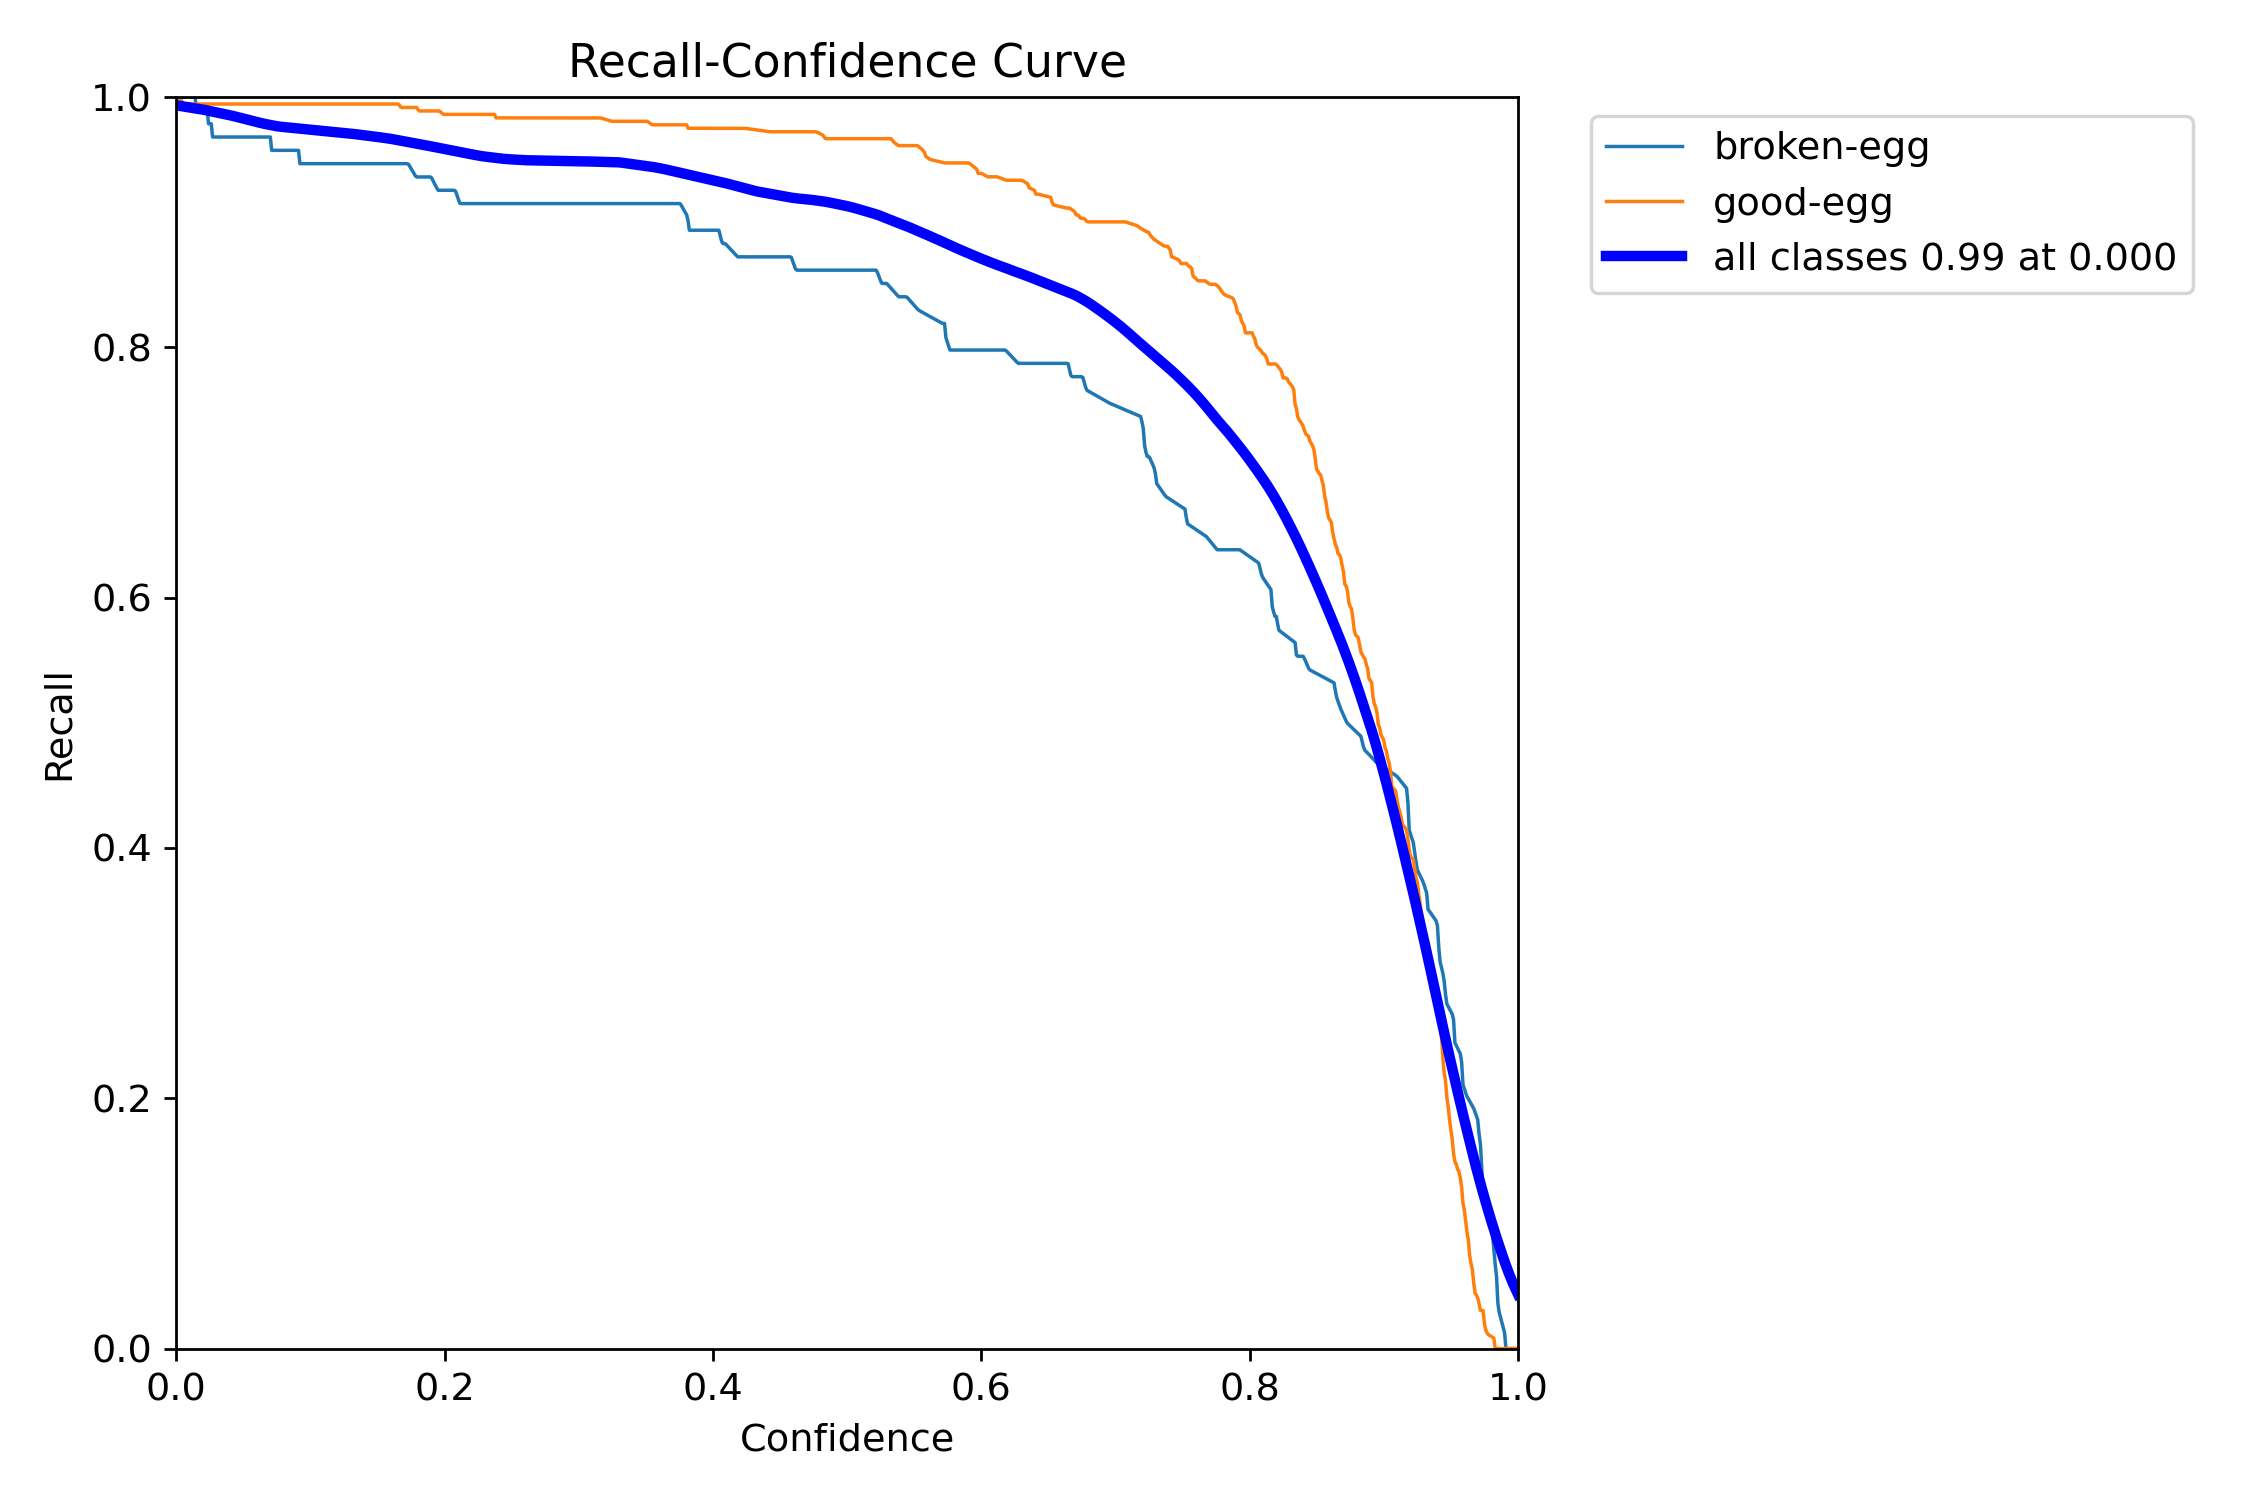

In [ ]:
import os
from IPython.display import Image, display

val_dir = "/content/runs/detect/student_stage16"
for fname in ["confusion_matrix_normalized.png", "F1_curve.png", "PR_curve.png", "P_curve.png","R_curve.png"]:
    fpath = os.path.join(val_dir, fname)
    if os.path.exists(fpath):
        display(Image(filename=fpath,width=1000))
    else:
        print(f" {fname} no encontrado.")

# **Resultados del modelo (YOLO8s Teacher)**

In [ ]:
import zipfile
import os

with zipfile.ZipFile('/content/egg_detection_dataset11.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [ ]:
# Ruta al modelo y dataset
model_path = 'Modelito_v11_best.pt'
data_yaml = './dataset/data.yaml'

In [ ]:
from ultralytics import YOLO

# Cargar modelo entrenado
model = YOLO(model_path)

# Reevaluar el modelo con el conjunto de test
metrics = model.val(data=data_yaml, split='test')


Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1205.0±373.9 MB/s, size: 33.2 KB)


val: Scanning /content/dataset/test/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


                   all         21        138      0.804      0.815      0.868      0.721
            broken-egg          8          8      0.834          1      0.967      0.817
              good-egg         14        130      0.773       0.63      0.769      0.625
Speed: 5.3ms preprocess, 11.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val4


In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob


# Buscar la carpeta de validación más reciente
val_dirs = sorted(glob.glob("runs/detect/val*"), key=os.path.getmtime)
results_dir = val_dirs[-1]  # la carpeta más reciente (ej. runs/detect/val8)

# Mostrar curva de métricas
results_img = os.path.join(results_dir, "results.png")
if os.path.exists(results_img):
    img = Image.open(results_img)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Curvas de aprendizaje (validación)")
    plt.show()
else:
    print("No se encontró 'results.png'")

# Mostrar matriz de confusión
conf_matrix_img = os.path.join(results_dir, "confusion_matrix_normalized.png")
if os.path.exists(conf_matrix_img):
    img = Image.open(conf_matrix_img)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Matriz de Confusión")
    plt.show()
else:
    print("No se encontró 'confusion_matrix.png'")


IndexError: list index out of range


0: 640x640 1 broken-egg, 12.2ms
1: 640x640 1 broken-egg, 12.2ms
2: 640x640 1 broken-egg, 14 good-eggs, 12.2ms
3: 640x640 1 good-egg, 12.2ms
4: 640x640 1 good-egg, 12.2ms
5: 640x640 (no detections), 12.2ms
6: 640x640 5 good-eggs, 12.2ms
7: 640x640 15 good-eggs, 12.2ms
8: 640x640 3 good-eggs, 12.2ms
9: 640x640 1 broken-egg, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


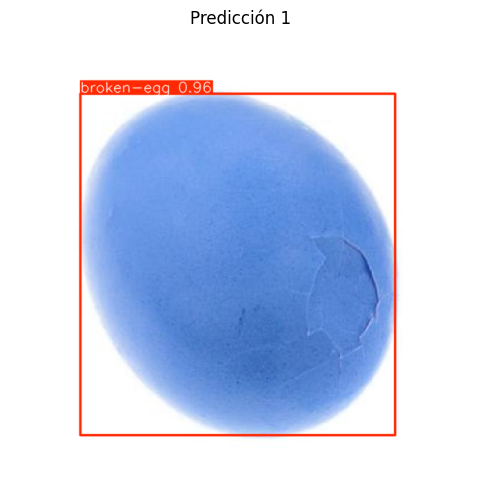

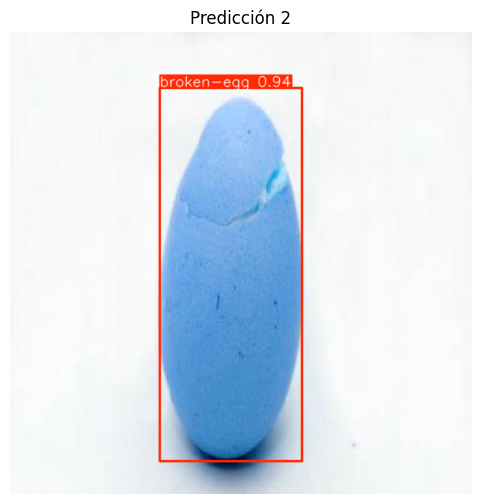

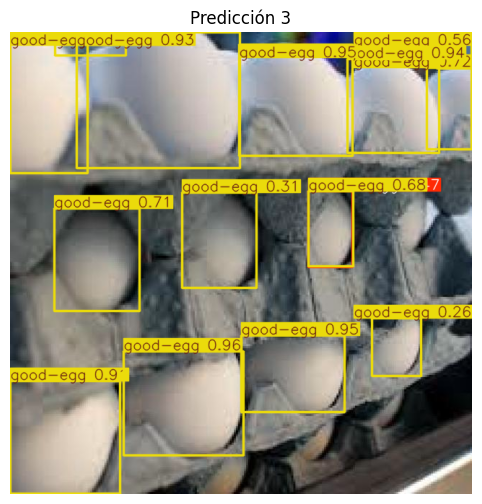

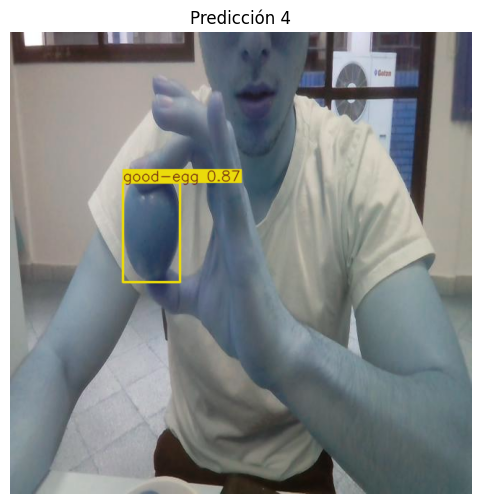

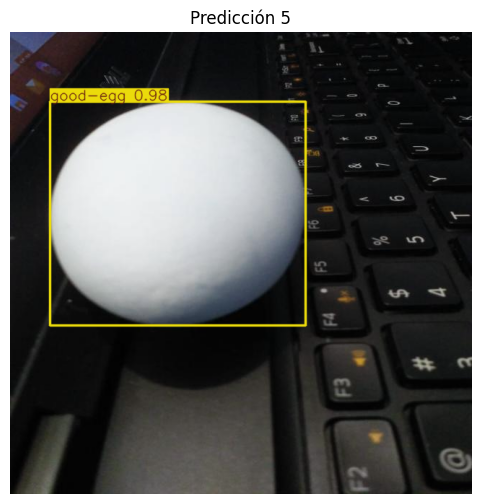

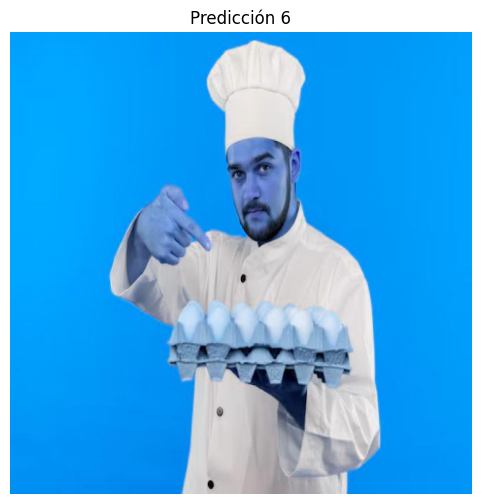

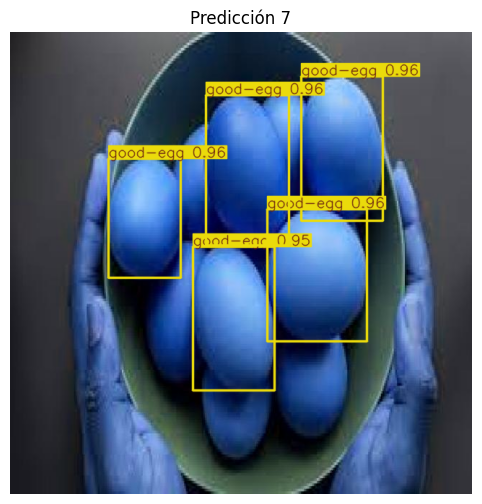

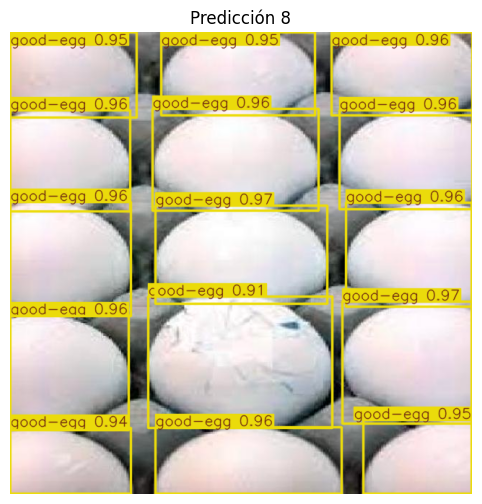

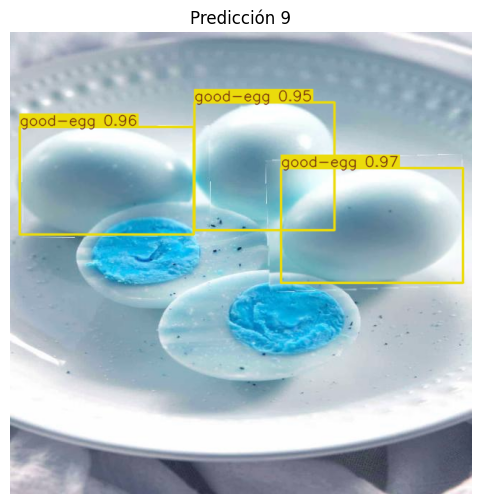

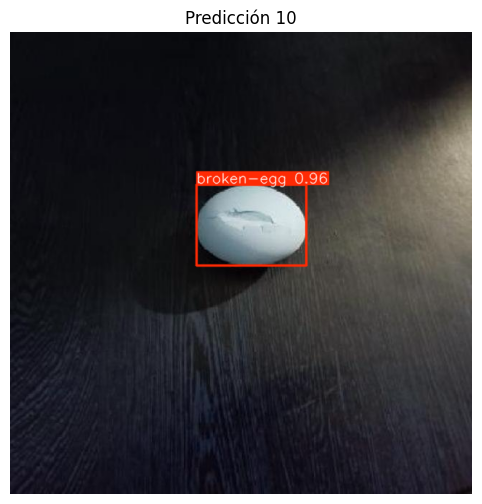

In [ ]:
import random
import glob
from PIL import Image
import matplotlib.pyplot as plt

# Obtener lista de imágenes del test set
test_images = glob.glob('./dataset/test/images/*.jpg')  # o .png según el caso
sample_images = random.sample(test_images, 10)

# Hacer predicciones
results = model(sample_images)

# Mostrar imágenes con predicciones
for i, r in enumerate(results):
    img = r.plot()  # dibuja predicciones sobre la imagen
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predicción {i+1}")
    plt.axis('off')
    plt.show()
